In [1]:
import datetime
import os
import pickle
import re
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from imblearn.over_sampling import SMOTE
from pandas.errors import MergeError
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
from statsmodels.graphics.tsaplots import plot_acf

# Importing data

Grab all the one to one merges and throw them into one large dataframe

Datasets we ignore
* ACCIDENT_CHAINAGE - gives distance to start of the road. However, is a one-to-many merge. Unclear how this would impact crashes, and even if it was 
                      a significant factor its unclear what policy there is
* ACCIDENT_LOCATION - gives specific address, but this granularity not needed when we have nodes. Likely useful when issuing reccomendations
* NODE_ID_COMPLEX_INT_ID - gives address as an int ID. Metadata that isn't needed
* ACCIDENT_EVENT - gives insight that might be useful for process mining, however not super conducive to classification models.

We are performing analysis at the person level - i.e. if a person gets into a crash, what does their severity look like?

We have editted data in the post 2005 to match column names pre 2005 - NODE file we drop LGA_NAME_ALL

In [2]:
path1 = "../Data pre 2005/"
path2 = "../Data post 2005/"
tables = os.listdir(path1)

def util_load_data(file_name:str) -> pd.DataFrame:
    """
    WARNING USES GLOBAL VARIABLE

    Helper function to load both csv files and concat them, because they are split for some reason
    """
    df1 = pd.read_csv(os.path.join(path1,file_name), low_memory=False)
    df2 = pd.read_csv(os.path.join(path2,file_name), low_memory=False)
    
    ## Special case -- need to make NODE post 2005 align, LGA_NAME_ALL is a new column
    if file_name == "NODE.csv":
        df2 = df2.drop("LGA_NAME_ALL", axis=1)

    col_2 = df2.columns
    
    for rename in zip(col_2, df1.columns):
        print(f"Renaming {rename}")

    df2.columns = df1.columns
    
    return pd.concat([df1,df2])

In [3]:
accidents_data = util_load_data("ACCIDENT.csv")
accidents_data.sample(5)

Renaming ('ACCIDENT_NO', 'ACCIDENT_NO')
Renaming ('ACCIDENTDATE', 'ACCIDENTDATE')
Renaming ('ACCIDENTTIME', 'ACCIDENTTIME')
Renaming ('ACCIDENT_TYPE', 'ACCIDENT_TYPE')
Renaming ('Accident Type Desc', 'Accident Type Desc')
Renaming ('DAY_OF_WEEK', 'DAY_OF_WEEK')
Renaming ('Day Week Description', 'Day Week Description')
Renaming ('DCA_CODE', 'DCA_CODE')
Renaming ('DCA Description', 'DCA Description')
Renaming ('DIRECTORY', 'DIRECTORY')
Renaming ('EDITION', 'EDITION')
Renaming ('PAGE', 'PAGE')
Renaming ('GRID_REFERENCE_X', 'GRID_REFERENCE_X')
Renaming ('GRID_REFERENCE_Y', 'GRID_REFERENCE_Y')
Renaming ('LIGHT_CONDITION', 'LIGHT_CONDITION')
Renaming ('Light Condition Desc', 'Light Condition Desc')
Renaming ('NODE_ID', 'NODE_ID')
Renaming ('NO_OF_VEHICLES', 'NO_OF_VEHICLES')
Renaming ('NO_PERSONS', 'NO_PERSONS')
Renaming ('NO_PERSONS_INJ_2', 'NO_PERSONS_INJ_2')
Renaming ('NO_PERSONS_INJ_3', 'NO_PERSONS_INJ_3')
Renaming ('NO_PERSONS_KILLED', 'NO_PERSONS_KILLED')
Renaming ('NO_PERSONS_NOT_INJ'

,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,DIRECTORY,...,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,NO_PERSONS_NOT_INJ,POLICE_ATTEND,ROAD_GEOMETRY,Road Geometry Desc,SEVERITY,SPEED_ZONE
129652,T20150007616,11/04/2015,14:10:00,4,Collision with a fixed object,7,Saturday,171,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICL...,VCS,...,5,0,1,0,4,2,5,Not at intersection,3,100
191065,T20190014910,8/08/2019,18:03:00,8,No collision and no object struck,4,Thursday,174,OUT OF CONTROL ON CARRIAGEWAY (ON STRAIGHT) ...,MEL,...,2,0,1,0,1,1,5,Not at intersection,3,60
149293,T20160014502,4/07/2016,11:25:00,2,Struck Pedestrian,2,Monday,101,PED EMERGES FROM IN FRONT OF PARKED OR STATION...,MEL,...,4,0,1,0,3,1,5,Not at intersection,3,50
13374,12004004692,27/01/2004,17.30.00,1,Collision with vehicle,3,Tuesday,130,REAR END(VEHICLES IN SAME LANE),MEL,...,2,0,1,0,1,2,1,Cross intersection,3,80
199007,T20200003599,15/02/2020,13:15:00,4,Collision with a fixed object,7,Saturday,181,OFF RIGHT BEND INTO OBJECT/PARKED VEHICLE ...,MEL,...,2,1,0,1,0,1,5,Not at intersection,1,80


In [4]:
## Util function to check that merges don't have messed up data
def merge_check(df1:pd.DataFrame, df2:pd.DataFrame, primary_key, foreign_key) -> None:

    # Doing with dtype might be better
    if isinstance(primary_key, list):
        # Grab all tuples of primary keys - tuples are hashable
        unique_keys1 = set(df1[sorted(primary_key)].itertuples(index=False, name=None))
        unique_keys2 = set(df2[sorted(primary_key)].itertuples(index=False, name=None))

    elif isinstance(primary_key, str):
        unique_keys1 = set(df1[primary_key].values)
        unique_keys2 = set(df2[foreign_key].values)
        
    else:
        raise TypeError("Primary key has the wrong type!")


    if not unique_keys1.issubset(unique_keys2):
        warnings.warn("The first dataframe has primary keys not in the second")

    if not unique_keys2.issubset(unique_keys1):
        warnings.warn("The second dataframe has foreign keys not in the first")

    

### Merging person

Because we're interested in a per person analysis, we join this table first. All other merges should be one - to one

In [5]:
person_data = util_load_data("PERSON.csv")


# Need to convert everything to an int for some reason - this is the only column whether the concat betwee two years breaks
person_data["INJ_LEVEL"] = person_data["INJ_LEVEL"].apply(lambda x:np.nan if x == ' ' else int(x))
person_data["HELMET_BELT_WORN"] = person_data["HELMET_BELT_WORN"].apply(lambda x:np.nan if x == ' ' else int(x))

# Check that all accident_no in person is in accidents and vice versa
merge_check(accidents_data, person_data, "ACCIDENT_NO", "ACCIDENT_NO")

Renaming ('ACCIDENT_NO', 'ACCIDENT_NO')
Renaming ('PERSON_ID', 'PERSON_ID')
Renaming ('VEHICLE_ID', 'VEHICLE_ID')
Renaming ('SEX', 'SEX')
Renaming ('AGE', 'AGE')
Renaming ('Age Group', 'Age Group')
Renaming ('INJ_LEVEL', 'INJ_LEVEL')
Renaming ('Inj Level Desc', 'Inj Level Desc')
Renaming ('SEATING_POSITION', 'SEATING_POSITION')
Renaming ('HELMET_BELT_WORN', 'HELMET_BELT_WORN')
Renaming ('ROAD_USER_TYPE', 'ROAD_USER_TYPE')
Renaming ('Road User Type Desc', 'Road User Type Desc')
Renaming ('LICENCE_STATE', 'LICENCE_STATE')
Renaming ('PEDEST_MOVEMENT', 'PEDEST_MOVEMENT')
Renaming ('POSTCODE', 'POSTCODE')
Renaming ('TAKEN_HOSPITAL', 'TAKEN_HOSPITAL')
Renaming ('EJECTED_CODE', 'EJECTED_CODE')


In [6]:
accidents_data = accidents_data.merge(person_data, validate = "one_to_many")



### Merging vehicles

In [7]:
vehicle_data = util_load_data("VEHICLE.csv")

# Check that all people in accidents are in vehicles and vice versa
merge_check(accidents_data, vehicle_data, ["ACCIDENT_NO","VEHICLE_ID"], ["ACCIDENT_NO","VEHICLE_ID"])

# We perform a test_merge since the merge check has highlighted some issues
test_merge = accidents_data.merge(vehicle_data, on=["ACCIDENT_NO","VEHICLE_ID"], how='outer', validate="many_to_one")

Renaming ('ACCIDENT_NO', 'ACCIDENT_NO')
Renaming ('VEHICLE_ID', 'VEHICLE_ID')
Renaming ('VEHICLE_YEAR_MANUF', 'VEHICLE_YEAR_MANUF')
Renaming ('VEHICLE_DCA_CODE', 'VEHICLE_DCA_CODE')
Renaming ('INITIAL_DIRECTION', 'INITIAL_DIRECTION')
Renaming ('ROAD_SURFACE_TYPE', 'ROAD_SURFACE_TYPE')
Renaming ('Road Surface Type Desc', 'Road Surface Type Desc')
Renaming ('REG_STATE', 'REG_STATE')
Renaming ('VEHICLE_BODY_STYLE', 'VEHICLE_BODY_STYLE')
Renaming ('VEHICLE_MAKE', 'VEHICLE_MAKE')
Renaming ('VEHICLE_MODEL', 'VEHICLE_MODEL')
Renaming ('VEHICLE_POWER', 'VEHICLE_POWER')
Renaming ('VEHICLE_TYPE', 'VEHICLE_TYPE')
Renaming ('Vehicle Type Desc', 'Vehicle Type Desc')
Renaming ('VEHICLE_WEIGHT', 'VEHICLE_WEIGHT')
Renaming ('CONSTRUCTION_TYPE', 'CONSTRUCTION_TYPE')
Renaming ('FUEL_TYPE', 'FUEL_TYPE')
Renaming ('NO_OF_WHEELS', 'NO_OF_WHEELS')
Renaming ('NO_OF_CYLINDERS', 'NO_OF_CYLINDERS')
Renaming ('SEATING_CAPACITY', 'SEATING_CAPACITY')
Renaming ('TARE_WEIGHT', 'TARE_WEIGHT')
Renaming ('TOTAL_NO_OCCU

C:\Users\kelvi\AppData\Local\Temp\ipykernel_33688\1719466344.py:19: UserWarning: The first dataframe has primary keys not in the second
  warnings.warn("The first dataframe has primary keys not in the second")
C:\Users\kelvi\AppData\Local\Temp\ipykernel_33688\1719466344.py:22: UserWarning: The second dataframe has foreign keys not in the first
  warnings.warn("The second dataframe has foreign keys not in the first")


In [8]:
display(test_merge[pd.isnull(test_merge["ACCIDENTDATE"])]["ACCIDENT_NO"].unique())
display(vehicle_data[vehicle_data["ACCIDENT_NO"] == '12000002288 '])
display(person_data[person_data["ACCIDENT_NO"] == '12000002288 '])


array(['12000002288 ', '12000002721 ', '12000003954 ', ...,
       'T20200018088', 'T20200018260', 'T20200018359'], dtype=object)

,ACCIDENT_NO,VEHICLE_ID,VEHICLE_YEAR_MANUF,VEHICLE_DCA_CODE,INITIAL_DIRECTION,ROAD_SURFACE_TYPE,Road Surface Type Desc,REG_STATE,VEHICLE_BODY_STYLE,VEHICLE_MAKE,...,VEHICLE_COLOUR_1,VEHICLE_COLOUR_2,CAUGHT_FIRE,INITIAL_IMPACT,LAMPS,LEVEL_OF_DAMAGE,OWNER_POSTCODE,TOWED_AWAY_FLAG,TRAFFIC_CONTROL,Traffic Control Desc
37,12000002288,A,NaN,1,E,1,Paved,Z,,,...,MRN,ZZ,0,5,9,9,NaN,2,00,No control
38,12000002288,B,1987.0,8,E,1,Paved,V,SEDAN,FORD,...,RED,ZZ,9,9,0,9,3777.0,2,99,Unknown


,ACCIDENT_NO,PERSON_ID,VEHICLE_ID,SEX,AGE,Age Group,INJ_LEVEL,Inj Level Desc,SEATING_POSITION,HELMET_BELT_WORN,ROAD_USER_TYPE,Road User Type Desc,LICENCE_STATE,PEDEST_MOVEMENT,POSTCODE,TAKEN_HOSPITAL,EJECTED_CODE
50,12000002288,01,,F,25.0,22-25,2.0,Serious injury,NaN,8.0,1,Pedestrians,,1,3182.0,Y,0
51,12000002288,A,A,U,NaN,unknown,4.0,Not injured,D,9.0,2,Drivers,Z,0,NaN,,0


Data Quality Issues: Inconsistency in Merging

This merge presents challenges due to fundamental data quality issues, particularly concerning either completeness or consistency. 

Example:

Consider a case with one crash event that involves two entities: a car with one driver and a pedestrian. 

In the `vehicles` data:

| ACCIDENT_ID | VEHICLE_ID |
|-------------|------------|
| 12000002288 | A          |
| 12000002288 | B          |

In the `people` data:

| ACCIDENT_ID | PERSON_ID | VEHICLE_ID |
|-------------|-----------|------------|
| 12000002288 | 1         |            |
| 12000002288 | A         | A          |

Here, there is a discrepancy between the `vehicles` and `people` data sets. The `vehicles` data set lists two vehicles (A and B) involved in the accident, while the `people` data set only accounts for one vehicle (A) and a pedestrian.

One of the primary reasons is that pedestrians aren't classified as vehicles (fair enough) and collisions with empty vehicles. We decide to do a left merge since we don't care about empty vehics

In [9]:
accidents_data = accidents_data.merge(vehicle_data, on=["ACCIDENT_NO","VEHICLE_ID"], how='left', validate="many_to_one")

### Merging atmospheric_cond

In [10]:
weather_data = util_load_data("ATMOSPHERIC_COND.csv")

# We'll grab the first atmospheric condition because we're interested what caused the crash
# Unlikely a change in weather will change severity
weather_data = (weather_data.sort_values("ATMOSPH_COND_SEQ", ascending=True)
                            .drop_duplicates("ACCIDENT_NO", keep='first'))

# Check that all accidents are in weather and vice versa
merge_check(accidents_data, weather_data, "ACCIDENT_NO", "ACCIDENT_NO")

accidents_data = accidents_data.merge(weather_data, how='outer', validate="many_to_one")

Renaming ('ACCIDENT_NO', 'ACCIDENT_NO')
Renaming ('ATMOSPH_COND', 'ATMOSPH_COND')
Renaming ('ATMOSPH_COND_SEQ', 'ATMOSPH_COND_SEQ')
Renaming ('Atmosph Cond Desc', 'Atmosph Cond Desc')


### Merging Nodes

Some interesting data quality concerns - Deg Urban Name seems to be a one to many w.r.t. each node. So theres often a repeat, curiously enough melbourne is designated as 'Metropolitan excluding CBD' and 'Metropoliton CBD only'. We treat this column as unuseable. Post Codes are also the same way

In [11]:
node_data = util_load_data("NODE.csv")

# Look at NODE_ID duplicates
display(node_data[node_data["ACCIDENT_NO"].duplicated(keep=False)].drop_duplicates(["LGA_NAME","Deg Urban Name"]))

# Remove Deg Urban Name and postcode no as it seems to be the cause of the failures
node_data = node_data.drop(["Deg Urban Name","Postcode No"], axis=1)
node_data = node_data.drop_duplicates()

# Check we are now unique w.r.t accident_no
assert node_data["ACCIDENT_NO"].nunique() == node_data.shape[0]

Renaming ('ACCIDENT_NO', 'ACCIDENT_NO')
Renaming ('NODE_ID', 'NODE_ID')
Renaming ('NODE_TYPE', 'NODE_TYPE')
Renaming ('VICGRID94_X', 'AMG_X')
Renaming ('VICGRID94_Y', 'AMG_Y')
Renaming ('LGA_NAME', 'LGA_NAME')
Renaming ('REGION_NAME', 'Region Name')
Renaming ('DEG_URBAN_NAME', 'Deg Urban Name')
Renaming ('Lat', 'Lat')
Renaming ('Long', 'Long')
Renaming ('POSTCODE_NO', 'Postcode No')


,ACCIDENT_NO,NODE_ID,NODE_TYPE,AMG_X,AMG_Y,LGA_NAME,Region Name,Deg Urban Name,Lat,Long,Postcode No
21,12000002504,29415,I,2495882.955,2409324.480,MELBOURNE,METROPOLITAN NORTH WEST REGION,Metropolitan CBD Only,-37.817090,144.953240,3008
22,12000002504,29415,I,2495882.955,2409324.480,MELBOURNE,METROPOLITAN NORTH WEST REGION,Metropolitan Excluding CBD,-37.817090,144.953240,3008
19981,22000003227,149955,N,2443023.283,2381543.813,GEELONG,SOUTH WESTERN REGION,Country,-38.065640,144.350730,3214
19982,22000003227,149955,N,2443023.283,2381543.813,GEELONG,SOUTH WESTERN REGION,Large Provincial Cities,-38.065640,144.350730,3214
20104,22000004695,127669,N,2476027.961,2405373.230,WYNDHAM,METROPOLITAN NORTH WEST REGION,Country,-37.852390,144.727600,3029
...,...,...,...,...,...,...,...,...,...,...,...
185998,T20150024536,296656,N,2314851.036,2465857.304,ARARAT,WESTERN REGION,TOWNS,-37.289389,142.911550,3377
188432,T20150003326,282353,I,2301358.714,2489591.754,NORTHERN GRAMPIANS,WESTERN REGION,TOWNS,-37.072792,142.765695,3380
197995,T20180022264,340949,N,2671313.833,2596614.542,WODONGA,NORTH EASTERN REGION,RURAL_VICTORIA,-36.113829,146.902958,3690
204784,T20190015764,579996,N,2564128.790,2479268.281,MURRINDINDI,NORTH EASTERN REGION,TOWNS,-37.184642,145.722317,3714


In [12]:
# Now we merge

# Check that all accidents are in node and vice versa
# Some accidents don't have node data
merge_check(accidents_data, node_data, ["ACCIDENT_NO", "NODE_ID"], ["ACCIDENT_NO", "NODE_ID"])


accidents_data = accidents_data.merge(node_data, how='outer', validate="many_to_one")

C:\Users\kelvi\AppData\Local\Temp\ipykernel_33688\1719466344.py:19: UserWarning: The first dataframe has primary keys not in the second
  warnings.warn("The first dataframe has primary keys not in the second")


### Merging ROAD_SURFACE_COND

Similar situation to atmospheric cond - we take the first condition

In [13]:
surface_cond_data = util_load_data("ROAD_SURFACE_COND.csv")

# We'll grab the first atmospheric condition because we're interested what caused the crash
# Unlikely a change in weather will change severity
surface_cond_data = (surface_cond_data.sort_values("SURFACE_COND_SEQ", ascending=True)
                            .drop_duplicates("ACCIDENT_NO", keep='first'))

# Check that all accidents are in surface_cond and vice versa
merge_check(surface_cond_data, weather_data, "ACCIDENT_NO", "ACCIDENT_NO")

accidents_data = accidents_data.merge(surface_cond_data, how='outer', validate="many_to_one")

Renaming ('ACCIDENT_NO', 'ACCIDENT_NO')
Renaming ('SURFACE_COND', 'SURFACE_COND')
Renaming ('Surface Cond Desc', 'Surface Cond Desc')
Renaming ('SURFACE_COND_SEQ', 'SURFACE_COND_SEQ')


# Data quality

Impressions:
Overall data looks fairly complete. Small amounts of nulls, even including the unkown values

Some issues around:

* Speed limits - 999, 888, 777. Effectively need to be treated as categorical (999 - not known, 888 Camping grounds/off road, 777 Other)
* One day as 0? Low impact on any analysis

Other comments:
* Almost always an injury, but fatalities are rare

In [14]:
# Check our primary key is unique
assert len(accidents_data.drop_duplicates(["ACCIDENT_NO","PERSON_ID"])) == accidents_data.shape[0]

In [15]:
# Column information
for col in accidents_data.columns:
    print(f"__{col}__")
    # Logic for determining if data is categorical or not - object trips up on string IDs
    # Threshold for category is arbitrary, anything over 15 probably doesn't fit neatly on a screen
    CAT_THRESH = 15
    if len(accidents_data[col].unique()) <= CAT_THRESH:
        display(accidents_data[col].value_counts())
    # If this is numerical get some info on the range
    elif accidents_data[col].dtype != object:
        display(accidents_data[col].describe())
    
    null_pctg = pd.isnull(accidents_data[col]).mean()
    print(f"{null_pctg*100:.2f}% of values are null")
    print("\r \r")
    

__ACCIDENT_NO__
0.00% of values are null
 
__ACCIDENTDATE__
0.00% of values are null
 
__ACCIDENTTIME__
0.05% of values are null
 
__ACCIDENT_TYPE__


ACCIDENT_TYPE
1    562357
4     80598
2     64933
6     19512
8     18416
5      5123
7      4995
3      3792
9       267
Name: count, dtype: int64

0.00% of values are null
 
__Accident Type Desc__


Accident Type Desc
Collision with vehicle               562357
Collision with a fixed object         80598
Struck Pedestrian                     64933
Vehicle overturned (no collision)     19512
No collision and no object struck     18416
collision with some other object       5123
Fall from or in moving vehicle         4995
Struck animal                          3792
Other accident                          267
Name: count, dtype: int64

0.00% of values are null
 
__DAY_OF_WEEK__


DAY_OF_WEEK
6    121534
5    114427
4    109833
3    105502
7    104105
2     99973
1     96960
0      7659
Name: count, dtype: int64

0.00% of values are null
 
__Day Week Description__


Day Week Description
Friday       123424
Thursday     113889
Saturday     112780
Wednesday    109109
Tuesday      105466
Monday        99323
Sunday        96002
Name: count, dtype: int64

0.00% of values are null
 
__DCA_CODE__


count    759993.000000
mean        133.538838
std          23.476418
min         100.000000
25%         116.000000
50%         130.000000
75%         146.000000
max         199.000000
Name: DCA_CODE, dtype: float64

0.00% of values are null
 
__DCA Description__
0.00% of values are null
 
__DIRECTORY__


DIRECTORY
MEL    586620
VCS    153831
        10145
VCD      4393
Name: count, dtype: int64

0.66% of values are null
 
__EDITION__


EDITION
40      327096
40.0    212260
9       101772
9.0      56452
46       23948
43       23294
         10145
ED35        22
Name: count, dtype: int64

0.66% of values are null
 
__PAGE__
0.66% of values are null
 
__GRID_REFERENCE_X__
0.66% of values are null
 
__GRID_REFERENCE_Y__
0.66% of values are null
 
__LIGHT_CONDITION__


LIGHT_CONDITION
1    512901
3    134649
2     60120
5     34080
9      9913
6      5982
4      2348
Name: count, dtype: int64

0.00% of values are null
 
__Light Condition Desc__


Light Condition Desc
Day                           512901
Dark Street lights on         134649
Dusk/Dawn                      60120
Dark No street lights          34080
Unknown                         9913
Dark Street lights unknown      5982
Dark Street lights off          2348
Name: count, dtype: int64

0.00% of values are null
 
__NODE_ID__


count    759993.000000
mean     148657.759348
std      134441.258399
min         -10.000000
25%       41079.000000
50%      102040.000000
75%      238870.000000
max      666096.000000
Name: NODE_ID, dtype: float64

0.00% of values are null
 
__NO_OF_VEHICLES__


count    759993.000000
mean          2.038423
std           0.890362
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          21.000000
Name: NO_OF_VEHICLES, dtype: float64

0.00% of values are null
 
__NO_PERSONS__


count    759993.000000
mean          3.505478
std           3.774508
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          97.000000
Name: NO_PERSONS, dtype: float64

0.00% of values are null
 
__NO_PERSONS_INJ_2__


count    759993.000000
mean          0.429774
std           0.784916
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: NO_PERSONS_INJ_2, dtype: float64

0.00% of values are null
 
__NO_PERSONS_INJ_3__


count    759993.000000
mean          1.105072
std           1.271990
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          43.000000
Name: NO_PERSONS_INJ_3, dtype: float64

0.00% of values are null
 
__NO_PERSONS_KILLED__


NO_PERSONS_KILLED
0     744945
1      13165
2       1439
3        257
4         94
11        38
5         26
6         22
7          7
Name: count, dtype: int64

0.00% of values are null
 
__NO_PERSONS_NOT_INJ__


count    759993.000000
mean          1.946744
std           3.359916
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          87.000000
Name: NO_PERSONS_NOT_INJ, dtype: float64

0.00% of values are null
 
__POLICE_ATTEND__


POLICE_ATTEND
1    587434
2    171237
9      1322
Name: count, dtype: int64

0.00% of values are null
 
__ROAD_GEOMETRY__


ROAD_GEOMETRY
5    349312
1    201440
2    189095
4     16161
3      2637
9       979
6       343
8        16
7        10
Name: count, dtype: int64

0.00% of values are null
 
__Road Geometry Desc__


Road Geometry Desc
Not at intersection      349312
Cross intersection       201440
T intersection           189095
Multiple intersection     16161
Y intersection             2637
Unknown                     979
Dead end                    343
Private property             16
Road closure                 10
Name: count, dtype: int64

0.00% of values are null
 
__SEVERITY__


SEVERITY
3    503062
2    241556
1     15063
4       312
Name: count, dtype: int64

0.00% of values are null
 
__SPEED_ZONE__


SPEED_ZONE
60     301820
50     112171
80     110595
100    107820
70      66747
999     23808
40      22436
110      7383
90       4455
888      1489
777       577
30        539
75        153
Name: count, dtype: int64

0.00% of values are null
 
__PERSON_ID__
0.00% of values are null
 
__VEHICLE_ID__
0.00% of values are null
 
__SEX__


SEX
M    426056
F    304782
U     29136
         19
Name: count, dtype: int64

0.00% of values are null
 
__AGE__


count    721850.000000
mean         36.296893
std          18.483849
min           0.000000
25%          22.000000
50%          33.000000
75%          49.000000
max         109.000000
Name: AGE, dtype: float64

5.02% of values are null
 
__Age Group__


Age Group
30-39      131698
40-49      108570
17-21       91760
50-59       80412
22-25       76540
26-29       64717
70+         42484
unknown     38143
5-12        29091
60-64       27914
64-69       20355
16-17       17345
0-4         16436
13-15       14528
Name: count, dtype: int64

0.00% of values are null
 
__INJ_LEVEL__


INJ_LEVEL
4.0    351427
3.0    283042
2.0    119200
1.0      6307
Name: count, dtype: int64

0.00% of values are null
 
__Inj Level Desc__


Inj Level Desc
Not injured       351427
Other injury      283042
Serious injury    119200
Fatality            6307
Unknown               17
Name: count, dtype: int64

0.00% of values are null
 
__SEATING_POSITION__


SEATING_POSITION
D     531686
LF    105695
LR     31190
RR     22634
NK     13715
OR     10833
CR      9476
PL      1980
CF      1027
PS        26
          17
Name: count, dtype: int64

4.17% of values are null
 
__HELMET_BELT_WORN__


HELMET_BELT_WORN
1.0    478310
9.0    160947
6.0     51964
8.0     38161
2.0     12205
3.0     11804
7.0      3563
5.0      2675
4.0       350
Name: count, dtype: int64

0.00% of values are null
 
__ROAD_USER_TYPE__
0.00% of values are null
 
__Road User Type Desc__


Road User Type Desc
Drivers               457831
Passengers            189505
Motorcyclists          41656
Pedestrians            31665
Bicyclists             27787
Unknown                 9582
Pillion Passengers      1967
Name: count, dtype: int64

0.00% of values are null
 
__LICENCE_STATE__


LICENCE_STATE
V    496686
     208265
Z     36918
O      6971
N      4961
Q      2124
S      2003
W       893
T       436
A       428
D       266
B        42
Name: count, dtype: int64

0.00% of values are null
 
__PEDEST_MOVEMENT__


PEDEST_MOVEMENT
0    729108
1     20701
8      3033
2      2547
3       997
7       904
9       782
4       766
6       713
5       411
         31
Name: count, dtype: int64

0.00% of values are null
 
__POSTCODE__


count    586214.000000
mean       3317.818254
std         368.808352
min           1.000000
25%        3076.000000
50%        3174.000000
75%        3550.000000
max        9999.000000
Name: POSTCODE, dtype: float64

22.87% of values are null
 
__TAKEN_HOSPITAL__


TAKEN_HOSPITAL
     494745
N    133494
Y    131754
Name: count, dtype: int64

0.00% of values are null
 
__EJECTED_CODE__


EJECTED_CODE
0    675940
1     46802
      16538
9     13040
2      6764
3       909
Name: count, dtype: int64

0.00% of values are null
 
__VEHICLE_YEAR_MANUF__


count    6.843180e+05
mean     2.171163e+03
std      6.527900e+04
min      0.000000e+00
25%      1.993000e+03
50%      2.000000e+03
75%      2.006000e+03
max      2.707200e+07
Name: VEHICLE_YEAR_MANUF, dtype: float64

9.96% of values are null
 
__VEHICLE_DCA_CODE__


VEHICLE_DCA_CODE
1    408029
2    257675
8     61608
3       671
        310
Name: count, dtype: int64

4.17% of values are null
 
__INITIAL_DIRECTION__


INITIAL_DIRECTION
S     132638
N     131058
E     127263
W     127118
SE     56200
NW     54591
SW     46625
NE     46619
NK      6181
Name: count, dtype: int64

4.17% of values are null
 
__ROAD_SURFACE_TYPE__


ROAD_SURFACE_TYPE
1.0    689097
3.0     24663
9.0      9440
2.0      5093
Name: count, dtype: int64

4.17% of values are null
 
__Road Surface Type Desc__


Road Surface Type Desc
Paved      689097
Gravel      24663
Unknown      9440
Unpaved      5093
Name: count, dtype: int64

4.17% of values are null
 
__REG_STATE__


REG_STATE
V    661490
      34671
Z     12733
N      8303
S      4140
Q      3975
W      1229
T       764
A       677
D       220
B        74
O        17
Name: count, dtype: int64

4.17% of values are null
 
__VEHICLE_BODY_STYLE__
4.17% of values are null
 
__VEHICLE_MAKE__
4.17% of values are null
 
__VEHICLE_MODEL__
4.17% of values are null
 
__VEHICLE_POWER__
79.84% of values are null
 
__VEHICLE_TYPE__


count    728293.000000
mean          5.149686
std          13.814047
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          99.000000
Name: VEHICLE_TYPE, dtype: float64

4.17% of values are null
 
__Vehicle Type Desc__
4.17% of values are null
 
__VEHICLE_WEIGHT__


count    60553.000000
mean      5238.618235
std       6487.180459
min          0.000000
25%       2140.000000
50%       2780.000000
75%       3300.000000
max      90000.000000
Name: VEHICLE_WEIGHT, dtype: float64

92.03% of values are null
 
__CONSTRUCTION_TYPE__


CONSTRUCTION_TYPE
R    582076
     146058
A       105
P        54
Name: count, dtype: int64

4.17% of values are null
 
__FUEL_TYPE__


FUEL_TYPE
P    494628
Z    104160
D     67467
M     33326
      21200
G      7246
E       132
z        59
O        50
S        13
R        12
Name: count, dtype: int64

4.17% of values are null
 
__NO_OF_WHEELS__


count    604744.000000
mean          3.970804
std           0.545310
min           0.000000
25%           4.000000
50%           4.000000
75%           4.000000
max          96.000000
Name: NO_OF_WHEELS, dtype: float64

20.43% of values are null
 
__NO_OF_CYLINDERS__


count    579114.000000
mean          4.802989
std           1.369048
min           0.000000
25%           4.000000
50%           4.000000
75%           6.000000
max          93.000000
Name: NO_OF_CYLINDERS, dtype: float64

23.80% of values are null
 
__SEATING_CAPACITY__


count    593214.000000
mean          5.411684
std           4.805186
min           0.000000
25%           5.000000
50%           5.000000
75%           5.000000
max          90.000000
Name: SEATING_CAPACITY, dtype: float64

21.94% of values are null
 
__TARE_WEIGHT__


count    649091.000000
mean       1614.498244
std        1696.665904
min           0.000000
25%        1103.000000
50%        1350.000000
75%        1555.000000
max       96000.000000
Name: TARE_WEIGHT, dtype: float64

14.59% of values are null
 
__TOTAL_NO_OCCUPANTS__


count    728292.000000
mean          2.024036
std           3.372737
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          96.000000
Name: TOTAL_NO_OCCUPANTS, dtype: float64

4.17% of values are null
 
__CARRY_CAPACITY__


count    317418.000000
mean       1702.025462
std        2166.428655
min           0.000000
25%        1015.000000
50%        1300.000000
75%        1455.000000
max       91000.000000
Name: CARRY_CAPACITY, dtype: float64

58.23% of values are null
 
__CUBIC_CAPACITY__
91.98% of values are null
 
__FINAL_DIRECTION__


FINAL_DIRECTION
S     128480
N     126023
E     124964
W     124285
SE     56906
NW     54812
SW     47624
NE     47419
NK     17780
Name: count, dtype: int64

4.17% of values are null
 
__DRIVER_INTENT__
4.17% of values are null
 
__VEHICLE_MOVEMENT__
4.17% of values are null
 
__TRAILER_TYPE__


TRAILER_TYPE
H    711612
B      8914
G      2451
J      1500
A      1104
C       676
E       413
D       403
F       400
L       279
I       231
        224
K        86
Name: count, dtype: int64

4.17% of values are null
 
__VEHICLE_COLOUR_1__
4.17% of values are null
 
__VEHICLE_COLOUR_2__
4.17% of values are null
 
__CAUGHT_FIRE__


CAUGHT_FIRE
2.0    664432
0.0     53719
9.0      7132
1.0      3010
Name: count, dtype: int64

4.17% of values are null
 
__INITIAL_IMPACT__
4.17% of values are null
 
__LAMPS__


LAMPS
2.0    383800
0.0    156285
1.0    114562
9.0     73646
Name: count, dtype: int64

4.17% of values are null
 
__LEVEL_OF_DAMAGE__


LEVEL_OF_DAMAGE
4.0    151810
3.0    142530
1.0    136638
5.0    107582
2.0    104733
6.0     51104
9.0     33896
Name: count, dtype: int64

4.17% of values are null
 
__OWNER_POSTCODE__


count    666509.000000
mean       3312.958274
std         381.436440
min           3.000000
25%        3074.000000
50%        3173.000000
75%        3518.000000
max        9999.000000
Name: OWNER_POSTCODE, dtype: float64

12.30% of values are null
 
__TOWED_AWAY_FLAG__


TOWED_AWAY_FLAG
1    240461
2    205686
1    137221
2    120993
9     23506
9       426
Name: count, dtype: int64

4.17% of values are null
 
__TRAFFIC_CONTROL__
4.17% of values are null
 
__Traffic Control Desc__
4.17% of values are null
 
__ATMOSPH_COND__


ATMOSPH_COND
1    631586
2     82682
9     36921
4      5335
7      1554
6      1032
5       682
3       201
Name: count, dtype: int64

0.00% of values are null
 
__ATMOSPH_COND_SEQ__


ATMOSPH_COND_SEQ
1    695877
0     64116
Name: count, dtype: int64

0.00% of values are null
 
__Atmosph Cond Desc__


Atmosph Cond Desc
Clear           631586
Raining          82682
Not known        36921
Fog               5335
Strong winds      1554
Dust              1032
Smoke              682
Snowing            201
Name: count, dtype: int64

0.00% of values are null
 
__NODE_TYPE__


NODE_TYPE
I    383265
N    372064
O      2871
         44
Name: count, dtype: int64

0.23% of values are null
 
__AMG_X__


count    7.582440e+05
mean     2.497369e+06
std      6.810418e+04
min      2.129297e+06
25%      2.489685e+06
50%      2.501820e+06
75%      2.516965e+06
max      2.920179e+06
Name: AMG_X, dtype: float64

0.23% of values are null
 
__AMG_Y__


count    7.582440e+05
mean     2.418632e+06
std      6.123202e+04
min      2.273433e+06
25%      2.393831e+06
50%      2.408777e+06
75%      2.419489e+06
max      2.818209e+06
Name: AMG_Y, dtype: float64

0.23% of values are null
 
__LGA_NAME__
0.23% of values are null
 
__Region Name__


Region Name
METROPOLITAN SOUTH EAST REGION    297388
METROPOLITAN NORTH WEST REGION    268520
SOUTH WESTERN REGION               50358
EASTERN REGION                     36426
WESTERN REGION                     36236
NORTHERN REGION                    34677
NORTH EASTERN REGION               34541
                                      98
Name: count, dtype: int64

0.23% of values are null
 
__Lat__


count    758244.000000
mean        -37.730730
std           0.554452
min         -39.033580
25%         -37.955871
50%         -37.821690
75%         -37.724760
max         -34.062380
Name: Lat, dtype: float64

0.23% of values are null
 
__Long__


count    758244.000000
mean        144.971330
std           0.766654
min         140.966178
25%         144.882901
50%         145.020678
75%         145.192910
max         149.757940
Name: Long, dtype: float64

0.23% of values are null
 
__SURFACE_COND__


SURFACE_COND
1    607313
2    123792
9     26637
3      1067
5       900
4       284
Name: count, dtype: int64

0.00% of values are null
 
__Surface Cond Desc__


Surface Cond Desc
Dry        607313
Wet        123792
Unknown     26637
Muddy        1067
Icy           900
Snowy         284
Name: count, dtype: int64

0.00% of values are null
 
__SURFACE_COND_SEQ__


SURFACE_COND_SEQ
1    695877
0     64116
Name: count, dtype: int64

0.00% of values are null
 


We have alot of columns now - many metadata and largely useless, others that 'cheat' the model i.e. police presence. Lets trim this down to a more useable dataset

#  Feature Engineering/EDA

Transforming some features into more useable variables

### Interested specifically in whether a crash results in a fatality

In [16]:
accidents_data["Fatal"] = accidents_data["INJ_LEVEL"] == 1

### Location

In [17]:
aust_file = gpd.read_file("../Rural shapefile/RA_2021_AUST_GDA2020.shp")
vic_shape = aust_file[aust_file["STE_NAME21"]  == "Victoria"]

# Simplifytin geopandas to make sjoin speed way up
vic_shape.geometry = vic_shape.simplify(tolerance=0.01)

c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
# Getting rid of the Nones in vic_shape
vic_shape = vic_shape[vic_shape['geometry'] != None]
vic_shape

,RA_CODE21,RA_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
7,20,Major Cities of Australia,2,Victoria,AUS,Australia,5055.2214,https://linked.data.gov.au/dataset/asgsed3/RA/20,"MULTIPOLYGON (((144.35827 -37.97480, 144.39507..."
8,21,Inner Regional Australia,2,Victoria,AUS,Australia,74228.4321,https://linked.data.gov.au/dataset/asgsed3/RA/21,"MULTIPOLYGON (((145.38428 -37.66178, 145.35258..."
9,22,Outer Regional Australia,2,Victoria,AUS,Australia,128080.1336,https://linked.data.gov.au/dataset/asgsed3/RA/22,"MULTIPOLYGON (((143.53660 -37.94778, 143.61072..."
10,23,Remote Australia,2,Victoria,AUS,Australia,20132.4608,https://linked.data.gov.au/dataset/asgsed3/RA/23,"MULTIPOLYGON (((146.54191 -38.74606, 146.54176..."


In [19]:
vic_shape.crs

<Geographic 2D CRS: EPSG:7844>
Name: GDA2020
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.55, 173.34, -8.47)
Datum: Geocentric Datum of Australia 2020
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

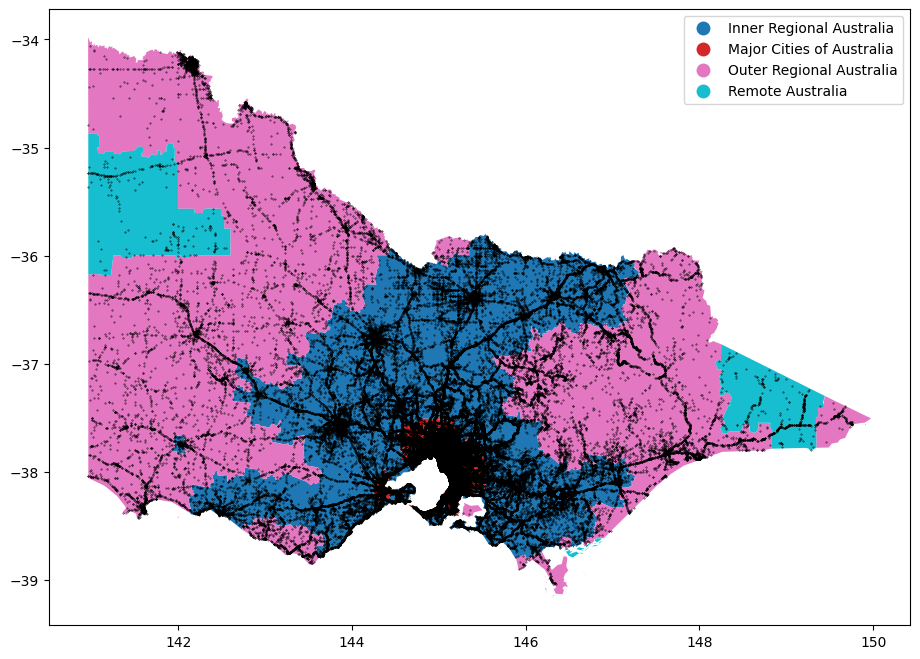

In [20]:
accident_gdf = gpd.GeoDataFrame(accidents_data, 
                        geometry=gpd.points_from_xy(accidents_data["Long"],accidents_data["Lat"]), 
                        crs="EPSG:7844")

# Group by geometry and count occurrences
gdf_aggregated = accident_gdf.groupby("geometry").agg({"ACCIDENT_NO":"nunique","Fatal":"sum"}).reset_index()

# Convert the aggregated DataFrame back to a GeoDataFrame
gdf_aggregated = gpd.GeoDataFrame(gdf_aggregated, geometry='geometry')


fig, ax = plt.subplots(figsize = (16,8))
# Plot the crashes geographically
vic_shape.plot(column='RA_NAME21', legend=True, ax=ax)
gdf_aggregated.plot(legend=True, markersize=0.1, color='black', ax=ax)

<Axes: >

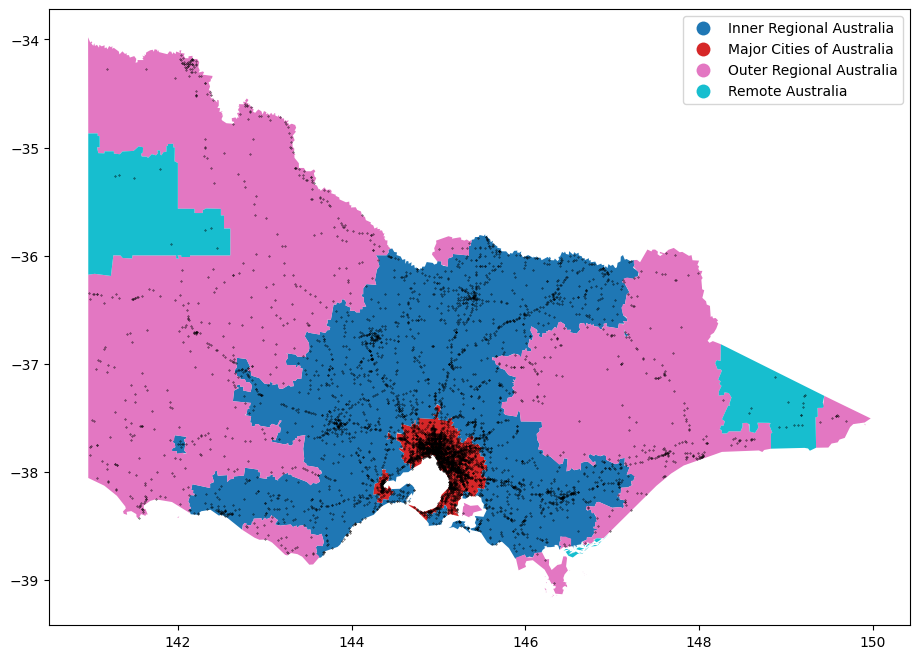

In [21]:
fig, ax = plt.subplots(figsize = (16,8))
# Plot the fatalities geographically
vic_shape.plot(column='RA_NAME21', legend=True, ax=ax)
gdf_aggregated[gdf_aggregated["Fatal"]>0].plot( legend=True, markersize=0.1, color='black', ax=ax)

In [1053]:
accidents_data = pd.DataFrame(gpd.sjoin(accident_gdf, vic_shape.loc[:,["RA_NAME21","geometry"]], how='inner', predicate='intersects'))
accidents_data = accidents_data.drop(["Lat", "Long"], axis=1)

### Time

In [1054]:
def calc_peak(time:datetime.time, day:int) -> str:
    """
    Calculates AM peak vs PM peak. Definitions taken from https://data.vicroads.vic.gov.au/metadata/evol.html

    Note that weekends do not have peaks
    """
    if day in [6,7]:
        return "Off peak"
    
    if pd.isnull(time):
        return np.nan

    AM_peak_start = datetime.time(hour=7, minute=30)
    AM_peak_end = datetime.time(hour=9, minute=0)
    PM_peak_start = datetime.time(hour=16, minute=30)
    PM_peak_end = datetime.time(hour=18, minute=0)

    if time >= AM_peak_start and time <= AM_peak_end:
        return "AM peak"
    elif time >= PM_peak_start and time <= PM_peak_end:
        return "PM peak"
    
    return "Off peak"

def to_time(time_str:str) -> datetime.time:
    """
    Specifically for the time string format we have converts to a datetime time object

    Splits the string on . and then takes the first two values as hour and minutes respectively
    """
    old = time_str
    if pd.isnull(time_str):
        return np.nan
    
    time_str = time_str.strip()
    # The split will break it into a string, we want them as ints
    time_split = re.split("\.|:", time_str)
    time = list(map(int, time_split))
    
    return datetime.time(int(time[0]),time[1])


In [1055]:
# Identifying whether things were during peak time
accidents_data["ACCIDENTTIME"] = accidents_data["ACCIDENTTIME"].map(to_time)
accidents_data["PEAK"] = accidents_data.loc[:,["DAY_OF_WEEK","ACCIDENTTIME"]].apply(lambda df:calc_peak(df["ACCIDENTTIME"],df["DAY_OF_WEEK"]),axis=1)

# Getting hour of day as a feature
accidents_data["ACCIDENTHOUR"] = accidents_data["ACCIDENTTIME"].apply(lambda x:np.nan if pd.isnull(x) else x.hour)

Year on year data

In [1056]:
accidents_data["ACCIDENTDATE"] = pd.to_datetime(accidents_data["ACCIDENTDATE"], dayfirst=True)
yearly_accidents = (accidents_data.groupby(pd.Grouper(key="ACCIDENTDATE", freq="Y"))
                                   .agg({"ACCIDENT_NO":"nunique", 
                                        "Fatal":"sum"})
                                   .reset_index())
yearly_accidents["ACCIDENTDATE"] = yearly_accidents["ACCIDENTDATE"].dt.year

In [1057]:
yearly_accidents

,ACCIDENTDATE,ACCIDENT_NO,Fatal
0,2000,17831,402
1,2001,17247,443
2,2002,17361,394
3,2003,16880,329
4,2004,16333,342
5,2005,16675,343
6,2006,13512,338
7,2007,13649,331
8,2008,13847,301
9,2009,13629,288


In [1058]:
yearly_accidents.to_clipboard()

In [1059]:
# Create a figure
fig = go.Figure()

# Add bar chart to the figure
fig.add_trace(go.Scatter(x=yearly_accidents['ACCIDENTDATE'], y=yearly_accidents['ACCIDENT_NO'], name='Yearly Accidents'))

# Add scatter plot to the figure on a secondary y-axis
fig.add_trace(go.Scatter(x=yearly_accidents['ACCIDENTDATE'], y=yearly_accidents["Fatal"], name='Yearly deaths', yaxis='y2'))

# Update layout to include a secondary y-axis
fig.update_layout(
    yaxis={"title":'Yearly accidents'},
    yaxis2={"title":'Yearly deaths', 
            "overlaying":'y', 
            "side":'right'},
    legend={"x":0.8, "y":1},
    width=1000, 
    height=600
)
# fig.write_image("../Plots/Crashes and deaths.png") 
fig.show()


In [1060]:
fig = px.line(yearly_accidents, x="ACCIDENTDATE", y="ACCIDENT_NO") 
fig.add_scatter(x=yearly_accidents['ACCIDENTDATE'], y=yearly_accidents['Fatal'], mode='markers', name='Fatal')

Lets look at seasonality

In [1061]:
accidents_data["MONTH"] = accidents_data["ACCIDENTDATE"].dt.month

month_time_series = accidents_data.groupby(pd.Grouper(key="ACCIDENTDATE", freq='M'))["ACCIDENT_NO"].nunique().reset_index()
month_time_series["Residuals"] =  month_time_series['ACCIDENT_NO'] - month_time_series['ACCIDENT_NO'].shift(1)


In [1062]:
px.line(month_time_series, x="ACCIDENTDATE", y="ACCIDENT_NO")

In [1063]:
# Clearly COVID is an exception that will mess with data
accidents_data = accidents_data[accidents_data['ACCIDENTDATE'].dt.year < 2020]

In [1064]:
px.line(month_time_series,x="ACCIDENTDATE", y="Residuals")

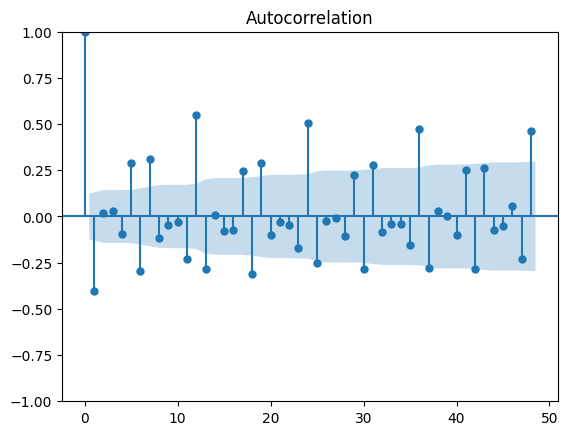

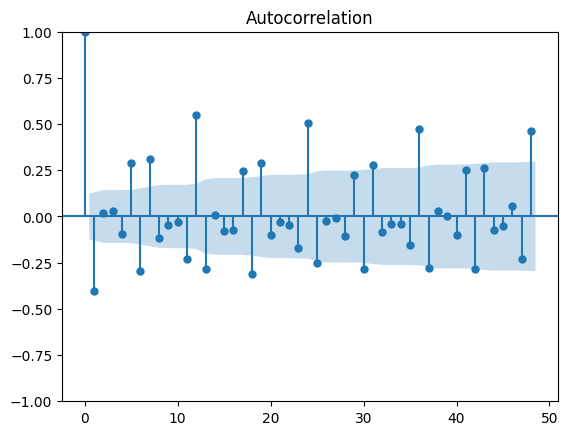

In [1065]:
plot_acf(month_time_series.dropna()["Residuals"], lags=48) 

In [1066]:
month_time_series["Month"] = month_time_series["ACCIDENTDATE"].dt.month

In [1067]:
px.scatter(month_time_series,x="Month",y='ACCIDENT_NO')

In [1068]:
# Since we see seasonality, lets add the average no of crashes for that month as a feature
month_averages = month_time_series.groupby("Month")["ACCIDENT_NO"].mean().to_dict()
accidents_data["Monthly Average"] = accidents_data["MONTH"].map(month_averages)

Time heatmaps

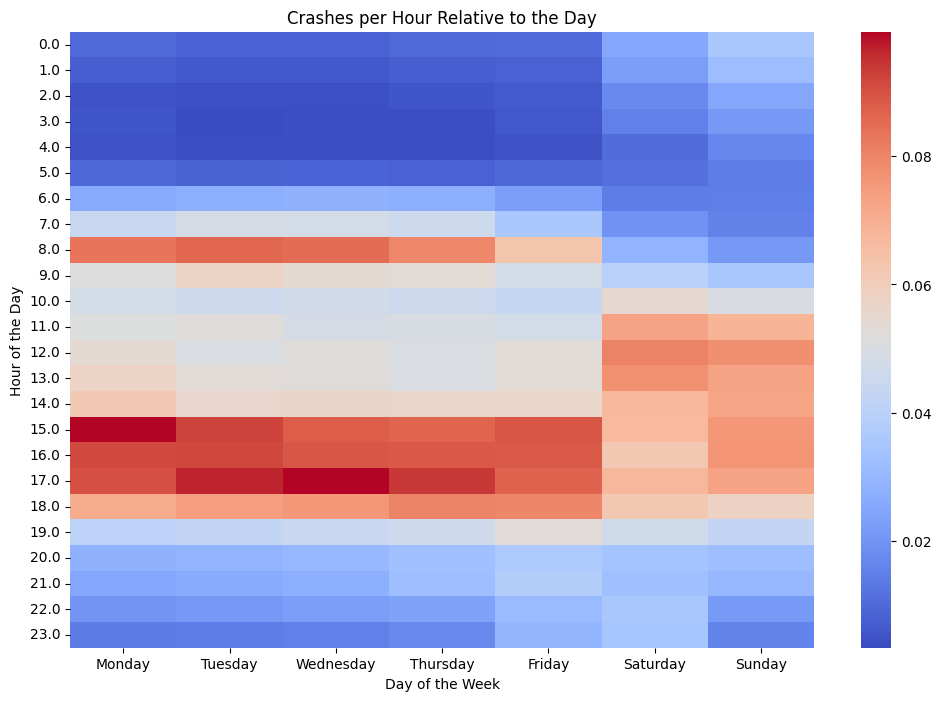

In [1069]:
# Group by 'Day_of_Week' and 'Time' and count the occurrences
grouped = accidents_data.groupby(['Day Week Description', 'ACCIDENTHOUR']).size().reset_index(name='Count')

# Pivot the DataFrame to have 'Day_of_Week' as columns, 'Time' as index and 'Count' as values
pivot_df = grouped.pivot(index="ACCIDENTHOUR", columns="Day Week Description", values="Count").fillna(0)

# Reorder columns by days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df.reindex(days_order, axis=1).fillna(0)

# Normalize the counts for each day
pivot_df_norm = pivot_df.divide(pivot_df.sum(axis=0), axis=1)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df_norm, cmap='coolwarm', fmt=".2f")
plt.title('Crashes per Hour Relative to the Day')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

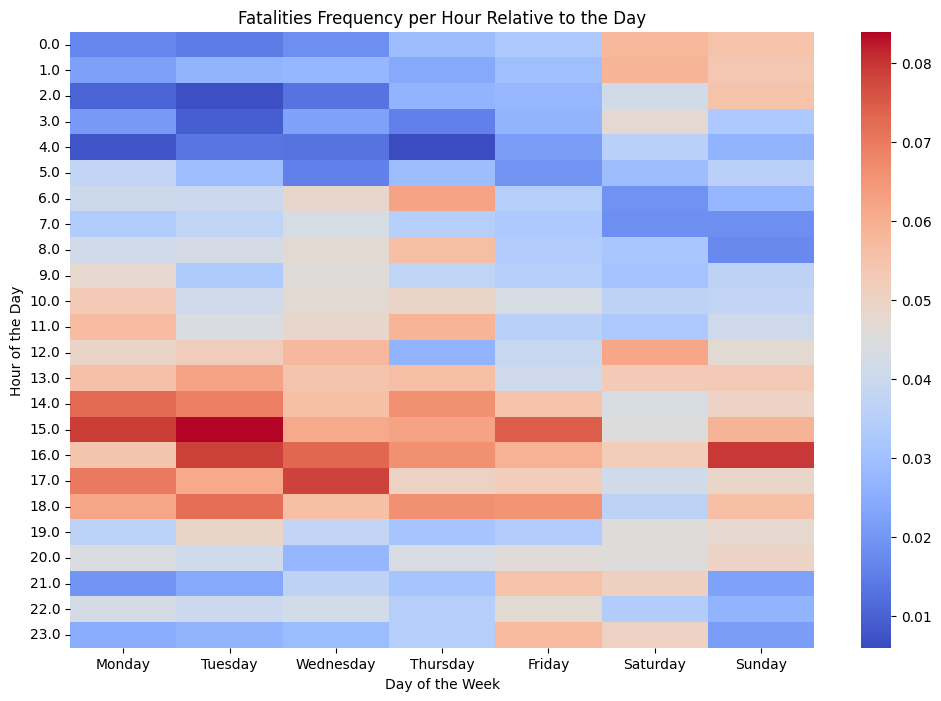

In [1070]:
# Group by 'Day_of_Week' and 'Time' and count the occurrences
grouped = accidents_data[accidents_data["Fatal"]].groupby(['Day Week Description', 'ACCIDENTHOUR']).size().reset_index(name='Count')

# Pivot the DataFrame to have 'Day_of_Week' as columns, 'Time' as index and 'Count' as values
pivot_df = grouped.pivot(index="ACCIDENTHOUR", columns="Day Week Description", values="Count").fillna(0)

# Reorder columns by days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df.reindex(days_order, axis=1).fillna(0)

# Normalize the counts for each day (multiply by 100 to get percentage)
pivot_df_norm = pivot_df.divide(pivot_df.sum(axis=0), axis=1)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df_norm, cmap='coolwarm', fmt=".2f")
plt.title('Fatalities Frequency per Hour Relative to the Day')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

In [1071]:
accidents_data.columns

Index(['ACCIDENT_NO', 'ACCIDENTDATE', 'ACCIDENTTIME', 'ACCIDENT_TYPE',
       'Accident Type Desc', 'DAY_OF_WEEK', 'Day Week Description', 'DCA_CODE',
       'DCA Description', 'DIRECTORY', 'EDITION', 'PAGE', 'GRID_REFERENCE_X',
       'GRID_REFERENCE_Y', 'LIGHT_CONDITION', 'Light Condition Desc',
       'NODE_ID', 'NO_OF_VEHICLES', 'NO_PERSONS', 'NO_PERSONS_INJ_2',
       'NO_PERSONS_INJ_3', 'NO_PERSONS_KILLED', 'NO_PERSONS_NOT_INJ',
       'POLICE_ATTEND', 'ROAD_GEOMETRY', 'Road Geometry Desc', 'SEVERITY',
       'SPEED_ZONE', 'PERSON_ID', 'VEHICLE_ID', 'SEX', 'AGE', 'Age Group',
       'INJ_LEVEL', 'Inj Level Desc', 'SEATING_POSITION', 'HELMET_BELT_WORN',
       'ROAD_USER_TYPE', 'Road User Type Desc', 'LICENCE_STATE',
       'PEDEST_MOVEMENT', 'POSTCODE', 'TAKEN_HOSPITAL', 'EJECTED_CODE',
       'VEHICLE_YEAR_MANUF', 'VEHICLE_DCA_CODE', 'INITIAL_DIRECTION',
       'ROAD_SURFACE_TYPE', 'Road Surface Type Desc', 'REG_STATE',
       'VEHICLE_BODY_STYLE', 'VEHICLE_MAKE', 'VEHICLE_MODEL

## Locations

Interested in what the relationship between accident frequencey and fatality rate is

<Axes: >

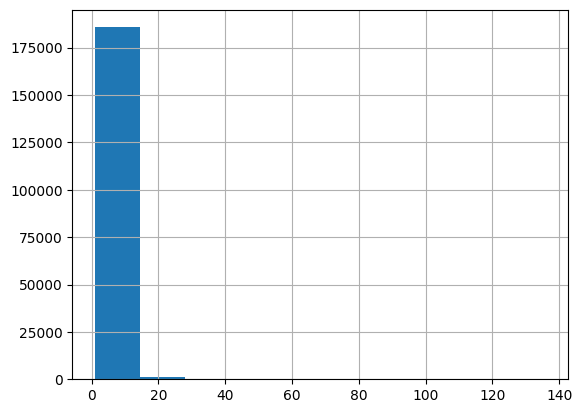

In [1072]:
accidents_data.groupby("NODE_ID")["ACCIDENT_NO"].nunique().hist(bins=10)

In [1073]:
# We want to consider whether locations with more accidents effect severity
node_crash_count = accidents_data.groupby("NODE_ID")["ACCIDENT_NO"].nunique().to_dict()
accidents_data["Node Crash"] = accidents_data["NODE_ID"].map(node_crash_count)

## Cleaning up some columns

We perform this when our logistic regression breaks due to collinearity

In [1074]:
# The values above 110 aren't real speed limits, just codes
accidents_data["SPEED_ZONE"] = accidents_data["SPEED_ZONE"].apply(lambda x:np.nan if x>110 else x)

In [1075]:
accidents_data["SPEED_ZONE"].isna().sum()

24476

In [1076]:
# Could use regex, but for smaller categories better to be precise
light_condition_map = {"Dark No street lights":"Dark",
                        "Dark Street lights off":"Dark",
                        "Dark Street lights unknown":"Dark",
                        'Dark Street lights on':"Dark",
                        "Unknown":"Unknown",
                        "Day":"Day",
                        "Dusk/Dawn":"Dusk/Dawn"}

accidents_data["Light Condition Simple"] = accidents_data["Light Condition Desc"].map(light_condition_map)

In [1077]:
vehicle_type = {
    "Car":"Car",
    "Station Wagon":"Station Wagon",
    "Motor Cycle":"Motor Cycle",
    "Utility":"Large vehicle",
    "Panel Van":"Station Wagon",
    "Taxi":"Car",
    "Motor Scooter":"Motor Cycle",
    "Prime Mover (No of Trailers Unknown)":"Large vehicle",
    "Moped":"Motor Cycle",
    "Rigid Truck(Weight Unknown)":"Large vehicle",
    "Bus/Coach":"Large vehicle",
    "Other Vehicle":"Other",
    "Unknown":"Other",
    "Bicycle":"Motor Cycle",
    "Mini Bus(9-13 seats)":"Large vehicle",
    "Tram":"Large vehicle",
    "Prime Mover Only":"Large vehicle",
    "Light Commercial Vehicle (Rigid) <= 4.5 Tonnes GVM":"Large vehicle",
    "Heavy Vehicle (Rigid) > 4.5 Tonnes":"Large vehicle",
    "Not Applicable":"Other",
    "Prime Mover B-Double":"Large vehicle",
    "Prime Mover - Single Trailer":"Large vehicle",
    "Prime Mover B-Triple":"Large vehicle",
    "Parked trailers":"Large vehicle",
    "Plant machinery and Agricultural equipment":"Large vehicle",
    "Train":"Large vehicle",
    "Quad Bike":"Motor Cycle",
    "Horse (ridden or drawn)":"Other"
}

accidents_data["Vehicle"] = accidents_data["Vehicle Type Desc"].map(vehicle_type)

#Assume anyone not a vehicle is a pedestrian
accidents_data["Vehicle"] = accidents_data["Vehicle"].fillna("Pedestrian")

In [1078]:
road_user = {
    "Bicyclists":"Cyclist",
    "Drivers":"Driver",
    "Motorcyclists":"Cyclist",
    "Passengers":"Passenger",
    "Pedestrians":"Pedestrian",
    "Pillion Passengers":"Cyclist",
    "Unknown":np.nan
}

accidents_data["Road User"] = accidents_data["Road User Type Desc"].map(road_user)

In [1079]:
# Taken from appendix of road safety, simplified for easier interpretability
helmet = {
    1:"Safety worn",
    2:"Safety not worn",
    3:"Safety worn",
    4:"Safety not worn",
    5:"Safety not worn",
    6:"Safety worn",
    7:"Safety not worn",
    8:"Not appropriate",
    9:"Unknown"
}

accidents_data["Helmet"] = accidents_data["HELMET_BELT_WORN"].map(helmet)

In [1080]:
# Need to remap because dust has no fatalities, and as a result causes issues in logistic regression and overfitting
weather = {"Strong winds":"Strong winds",
"Clear":"Clear",
"Not known":"Not known",
"Raining":"Raining",
"Fog":"Low visibility",
"Dust":"Low visibility",
"Snowing":"Snowing",
"Smoke":"Low visibility"}

accidents_data["Weather"] = accidents_data["Atmosph Cond Desc"].map(weather)

In [1081]:
seating_position = {
    "LF":"Front",
    "D ":"Driver",
    "PL":"Motorcycle Passenger",
    "LR":"Rear",
    "RR":"Rear",
    "CR":"Rear",
    "NK":"Unkown",
    "OR":"Rear",
    "CF":"Front",
    "PS":"Motorcycle Passenger",
    "  ":"Ped",
}

accidents_data["SEATING_POSITION"] = accidents_data["SEATING_POSITION"].map(seating_position)
accidents_data["SEATING_POSITION"] = accidents_data["SEATING_POSITION"].fillna("Ped")

In [1082]:
# This is null for pedestrians, so must change
accidents_data["Road Surface Type Desc"] = accidents_data["Road Surface Type Desc"].fillna("Ped")

In [1083]:
# Unkown values in SEX column are causing issues
accidents_data["SEX"] = accidents_data["SEX"].apply(lambda x: x if x in ['M', 'F'] else np.nan)

In [1084]:
# Unkown values in SEX column are causing issues
accidents_data["SEX"] = accidents_data["SEX"].apply(lambda x: x if x in ['M', 'F'] else np.nan)

In [1085]:
# TOTAL_NO_OCCUPANTS is empty if its a pedestrian, easy to assume 1 (not perfect)
accidents_data["TOTAL_NO_OCCUPANTS"] = accidents_data["TOTAL_NO_OCCUPANTS"].fillna(1)


# Feature Trimming

In [1086]:
with open("columns.txt","w") as f:
    for col in accidents_data.columns:
        f.write(f'"{col}", \r')

In [1087]:
columns_to_use = [
# "ACCIDENT_NO", 
# "ACCIDENTDATE", 
# "ACCIDENTTIME", 
"ACCIDENTHOUR",
# "ACCIDENT_TYPE",
"Accident Type Desc", 
# "DAY_OF_WEEK", # We'll treat day of week as a category
"Day Week Description",
# "DCA_CODE", 
# "DCA Description", # Could be useful, but simply too many
# "DIRECTORY", # We aren't using Melways
# "EDITION", 
# "PAGE", 
# "GRID_REFERENCE_X", 
# "GRID_REFERENCE_Y", 
# "LIGHT_CONDITION",  
# "NODE_ID", 
"NO_OF_VEHICLES", 
"NO_PERSONS", 
# "NO_PERSONS_INJ_2", # These categories 'leak' data 
# "NO_PERSONS_INJ_3", 
# "NO_PERSONS_KILLED", 
# "NO_PERSONS_NOT_INJ", 
# "POLICE_ATTEND", 
# "ROAD_GEOMETRY", 
# "Road Geometry Desc", # Perfect collinearity - rather use node_type
# "SEVERITY", # We're interested in severity on a per person basis
"SPEED_ZONE", 
# "PERSON_ID", 
# "VEHICLE_ID", 
"SEX", 
"AGE", # Age has 6% missing - could be an issue
# "Age Group", 
# "INJ_LEVEL", 
# "Inj Level Desc", 
"SEATING_POSITION", 
# "HELMET_BELT_WORN", 
"Helmet",
# "ROAD_USER_TYPE", 
# "Road User Type Desc", 
"Road User",
# "LICENCE_STATE", 
# "PEDEST_MOVEMENT", # Useful, but we need to build up ensemble methods for this
# "POSTCODE", 
# "TAKEN_HOSPITAL", # Leaking data 
# "EJECTED_CODE", 
"VEHICLE_YEAR_MANUF", 
# "VEHICLE_DCA_CODE", 
# "INITIAL_DIRECTION", 
# "ROAD_SURFACE_TYPE", 
"Road Surface Type Desc", 
# "REG_STATE", 
# "VEHICLE_BODY_STYLE", 
# "VEHICLE_MAKE", # More interpretable if we use type
# "VEHICLE_MODEL", 
# "VEHICLE_POWER", # Too many NA's
# "VEHICLE_TYPE", 
"Vehicle", 
# "VEHICLE_WEIGHT", # Too many Na's 
# "CONSTRUCTION_TYPE", 
# "FUEL_TYPE", 
# "NO_OF_WHEELS", 
# "NO_OF_CYLINDERS", 
# "SEATING_CAPACITY", 
# "TARE_WEIGHT", 
"TOTAL_NO_OCCUPANTS", 
# "CARRY_CAPACITY", 
# "CUBIC_CAPACITY", 
# "FINAL_DIRECTION", 
# "DRIVER_INTENT", # Unclear what this is
# "VEHICLE_MOVEMENT", 
# "TRAILER_TYPE", 
# "VEHICLE_COLOUR_1", 
# "VEHICLE_COLOUR_2", 
# "CAUGHT_FIRE", 
# "INITIAL_IMPACT", 
# "LAMPS", 
# "LEVEL_OF_DAMAGE", # Leaking data
# "OWNER_POSTCODE", 
# "TOWED_AWAY_FLAG", 
# "TRAFFIC_CONTROL", 
# "Traffic Control Desc", 
# "ATMOSPH_COND", 
# "ATMOSPH_COND_SEQ", 
# "Atmosph Cond Desc", 
"Weather",
"NODE_TYPE", 
# "AMG_X", # These are inconsistent since the move to vicgrid
# "AMG_Y", 
# "LGA_NAME", 
# "Region Name", 
# "Lat", 
# "Long", 
# "SURFACE_COND", 
"RA_NAME21",
"Surface Cond Desc", 
"Light Condition Simple",
"MONTH",
"PEAK",
"Node Crash",
"Fatal"
# "SURFACE_COND_SEQ", 
]

In [1088]:
accidents_data = accidents_data.loc[:,columns_to_use]

# Hypothesis tests

While all features do show significance, applying Cramers in order to get an understanding of the strength of the relationship shows

We're specifically interested in the how the data features will impact severity

In [1089]:
def cramers_corrected_stat(contingency_table):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher, 
    Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum()
    phi2 = chi2/n
    r,k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def logistic_regression(df:pd.DataFrame, column:str, categorical:bool) -> None:
    """
    Does logistic regressions
    """
    df_copy = df.copy()
    if categorical:
        test_data = df_copy.loc[:,["Fatal" ,column]].dropna()
        # Reshape the feature array
        # One-hot encode the categorical variables
        encoder = OneHotEncoder()
        # Reshaping the array to 2D
        X_encoded = encoder.fit_transform(test_data[column].values.reshape(-1, 1)).toarray()

        # Labels for the one-hot encoded features
        feature_labels = encoder.get_feature_names_out([column])
        
        # Response variable
        y = test_data['Fatal']

        # Using statsmodels for more detailed statistics
        X_encoded = sm.add_constant(X_encoded)
        model = sm.Logit(y, X_encoded)
        result = model.fit()

        # Summary of regression, including p-values
        print(result.summary())
        print(feature_labels)

        coefficients = result.params[1:]  # Skipping the constant
        

        plt.figure(figsize=(15, 8))
        y_pos = np.arange(len(feature_labels))
        plt.barh(y_pos, coefficients, align='center', alpha=0.7)
        plt.yticks(y_pos, feature_labels)
        plt.xlabel('Coefficient Value')
        plt.title('Impact of Each Class on Prediction')
        plt.show()
        
    else:
        
        data = df_copy.loc[:,["Fatal",column]].dropna()
        # Reshape the feature array
        X = data[column].values.reshape(-1, 1)

        # Response variable
        y = data['Fatal']

        # Using statsmodels for more detailed statistics
        X_with_const = sm.add_constant(X)  # Adding a constant (i.e., bias or intercept term)
        model = sm.Logit(y, X_with_const)
        result = model.fit()

        # Summary of regression, including p-values
        print(result.summary())

        # Generate data for the curve
        x_test = np.linspace(data[column].min(), data[column].max(), 300)
        x_test_with_const = sm.add_constant(x_test)
        y_prob = result.predict(x_test_with_const)

        # Plot logistic regression curve
        plt.plot(x_test, y_prob, label='Logistic Regression Curve')

        # Labels and title
        plt.xlabel('Total Number of Occupants')
        plt.ylabel('Probability of Fatality')
        data.groupby(column).apply(lambda df:df["Fatal"].sum()/df.shape[0]).plot(label="Observed")
        plt.title('Logistic Regression Fit')
        plt.legend()
        plt.show()


__ACCIDENTHOUR__
Optimization terminated successfully.
         Current function value: 0.047646
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               740749
Model:                          Logit   Df Residuals:                   740747
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                0.002831
Time:                        00:11:34   Log-Likelihood:                -35294.
converged:                       True   LL-Null:                       -35394.
Covariance Type:            nonrobust   LLR p-value:                 1.728e-45
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3401      0.033   -131.938      0.000      -4.405      -4.276
x1          

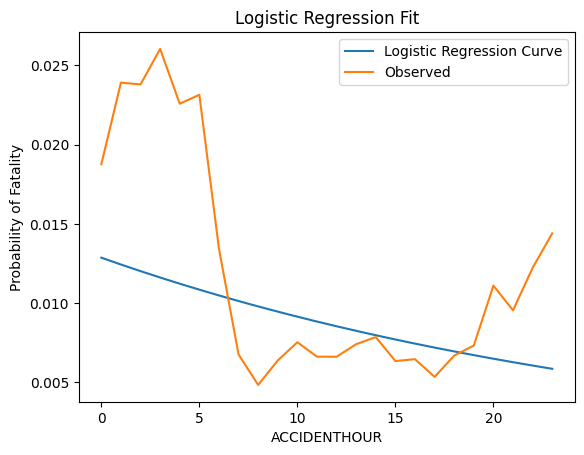

__Accident Type Desc__


Accident Type Desc
Collision with a fixed object        0.027599
Collision with vehicle               0.004796
Fall from or in moving vehicle       0.006237
No collision and no object struck    0.003878
Other accident                       0.008230
Struck Pedestrian                    0.014115
Struck animal                        0.008743
Vehicle overturned (no collision)    0.012876
collision with some other object     0.008952
Name: Fatal, dtype: float64

4754.766135849185 0.0
0.08003017591384405
         Current function value: 0.045461
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741114
Method:                           MLE   Df Model:                            9
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.04919
Time:                        00:11:40   Log-Likelihood:                -33692.
converged:                      False   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2332        nan        nan        nan         nan         nan
x1             0.6712        nan        nan        nan         nan         nan
x2            -1.1020        nan        nan        n

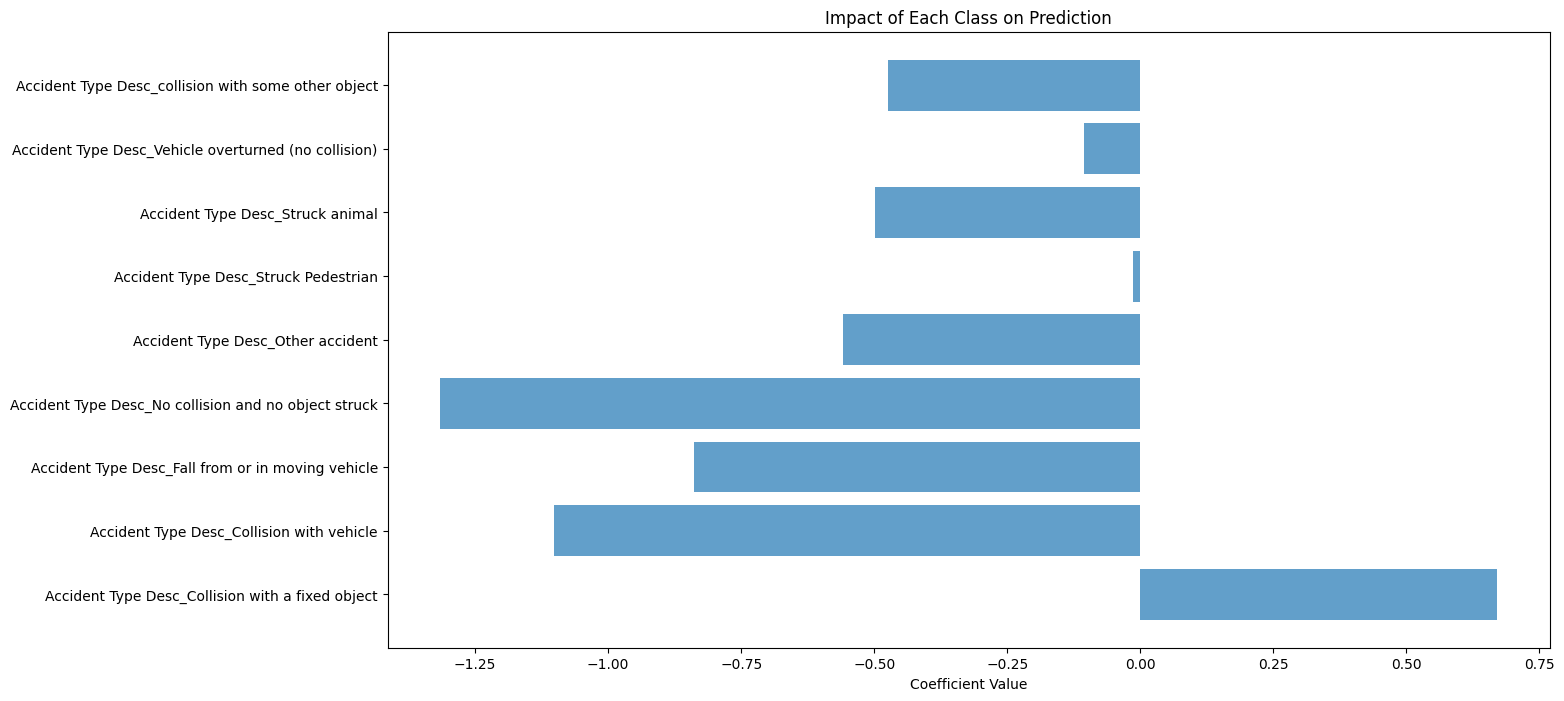

__Day Week Description__


Day Week Description
Friday       0.008109
Monday       0.007944
Saturday     0.009455
Sunday       0.010526
Thursday     0.007507
Tuesday      0.007283
Wednesday    0.007184
Name: Fatal, dtype: float64

114.02949230385929 2.917334123236445e-22
0.012073300371838779
Optimization terminated successfully.
         Current function value: 0.047739
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741116
Method:                           MLE   Df Model:                            7
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                0.001550
Time:                        00:11:43   Log-Likelihood:                -35381.
converged:                       True   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                 9.835e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1946   3.36e+05  -1.25e-05   

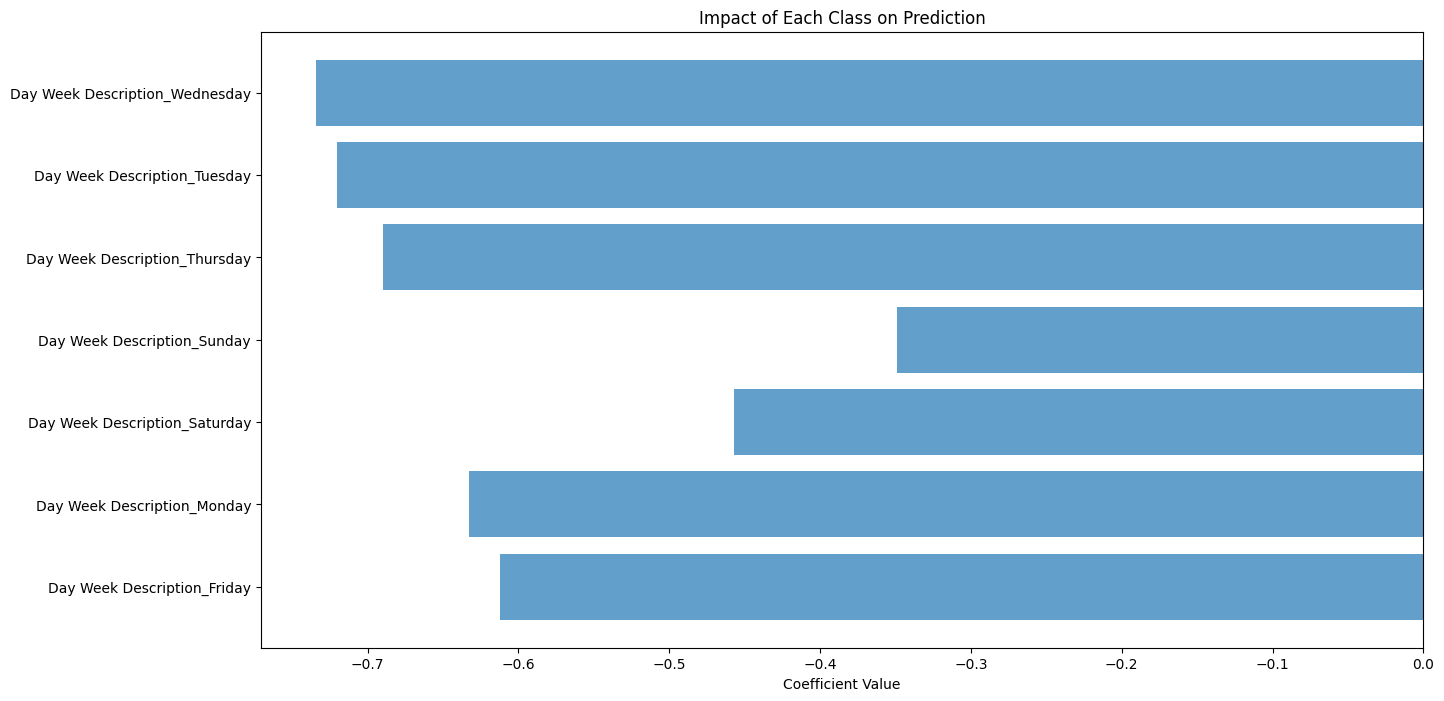

__NO_OF_VEHICLES__
Optimization terminated successfully.
         Current function value: 0.046387
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741122
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.02983
Time:                        00:11:46   Log-Likelihood:                -34379.
converged:                       True   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2002      0.036    -88.728      0.000      -3.271      -3.130
x1       

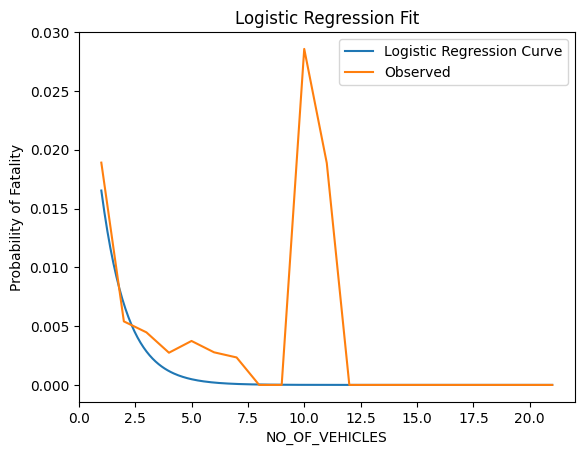

__NO_PERSONS__
Optimization terminated successfully.
         Current function value: 0.047531
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741122
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                0.005907
Time:                        00:11:48   Log-Likelihood:                -35226.
converged:                       True   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                 4.768e-93
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3405      0.027   -161.778      0.000      -4.393      -4.288
x1           

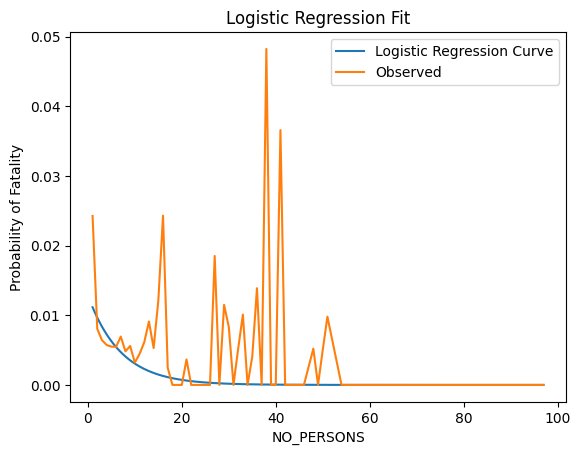

__SPEED_ZONE__


SPEED_ZONE
30.0     0.001912
40.0     0.002461
50.0     0.003962
60.0     0.004041
70.0     0.006467
75.0     0.013072
80.0     0.008346
90.0     0.018178
100.0    0.026293
110.0    0.029070
Name: Fatal, dtype: float64

5483.270336296656 0.0
0.08739980750364955
Optimization terminated successfully.
         Current function value: 0.046001
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               716648
Model:                          Logit   Df Residuals:                   716646
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.05761
Time:                        00:11:51   Log-Likelihood:                -32966.
converged:                       True   LL-Null:                       -34982.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0580      0.059   -136.398      0.000      -8.17

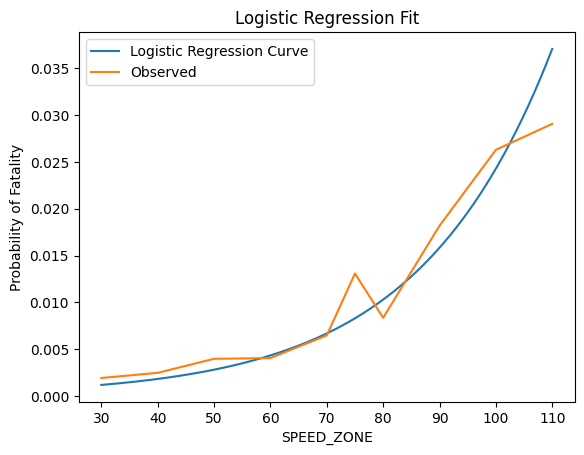

__SEX__


SEX
F    0.005822
M    0.010548
Name: Fatal, dtype: float64

455.1253343911626 5.529869225061803e-101
0.025240268252782323
         Current function value: 0.049001
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               712834
Model:                          Logit   Df Residuals:                   712831
Method:                           MLE   Df Model:                            2
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                0.006773
Time:                        00:11:55   Log-Likelihood:                -34930.
converged:                      False   LL-Null:                       -35168.
Covariance Type:            nonrobust   LLR p-value:                3.529e-104
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2273        nan        nan        nan         nan         nan
x1            -1.9130        nan        nan        nan         nan         nan
x2            -1.3139        nan        nan        n

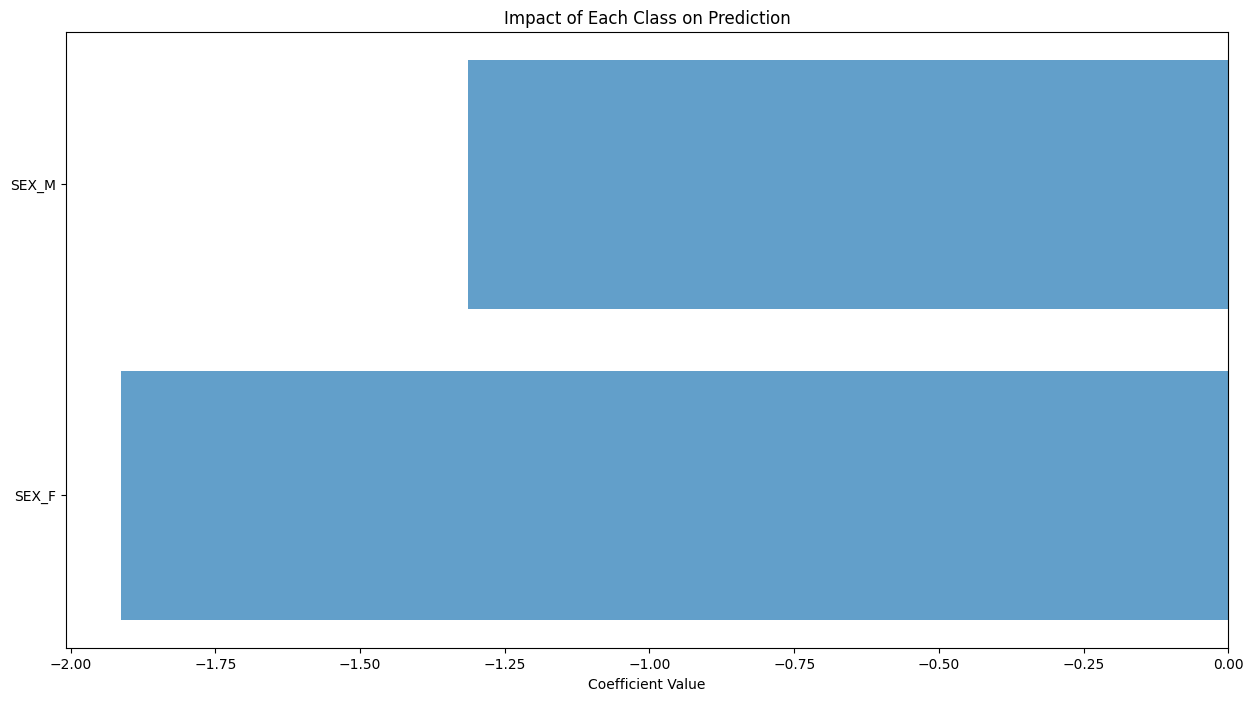

__AGE__
Optimization terminated successfully.
         Current function value: 0.049304
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               703853
Model:                          Logit   Df Residuals:                   703851
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                0.009968
Time:                        00:11:57   Log-Likelihood:                -34703.
converged:                       True   LL-Null:                       -35052.
Covariance Type:            nonrobust   LLR p-value:                5.405e-154
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4265      0.030   -178.322      0.000      -5.486      -5.367
x1             0.0175

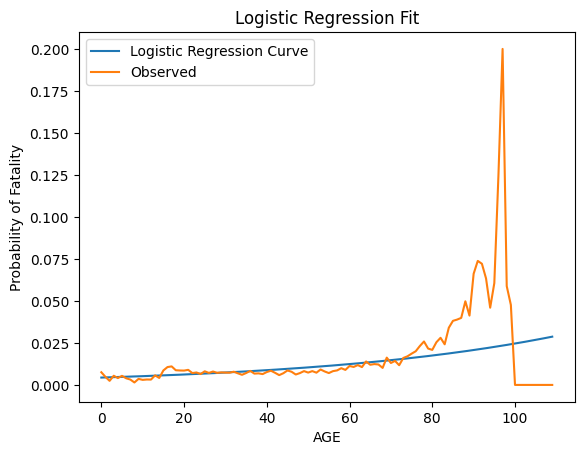

__SEATING_POSITION__


SEATING_POSITION
Driver                  0.007586
Front                   0.006799
Motorcycle Passenger    0.012994
Ped                     0.029964
Rear                    0.005819
Unkown                  0.007648
Name: Fatal, dtype: float64

1900.9842824785171 0.0
0.05057923074643537
         Current function value: 0.047012
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741117
Method:                           MLE   Df Model:                            6
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.01675
Time:                        00:12:03   Log-Likelihood:                -34842.
converged:                      False   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                3.163e-253
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9531        nan        nan        nan         nan         nan
x1            -0.9207        nan        nan        nan         nan         nan
x2            -1.0310        nan        nan        n

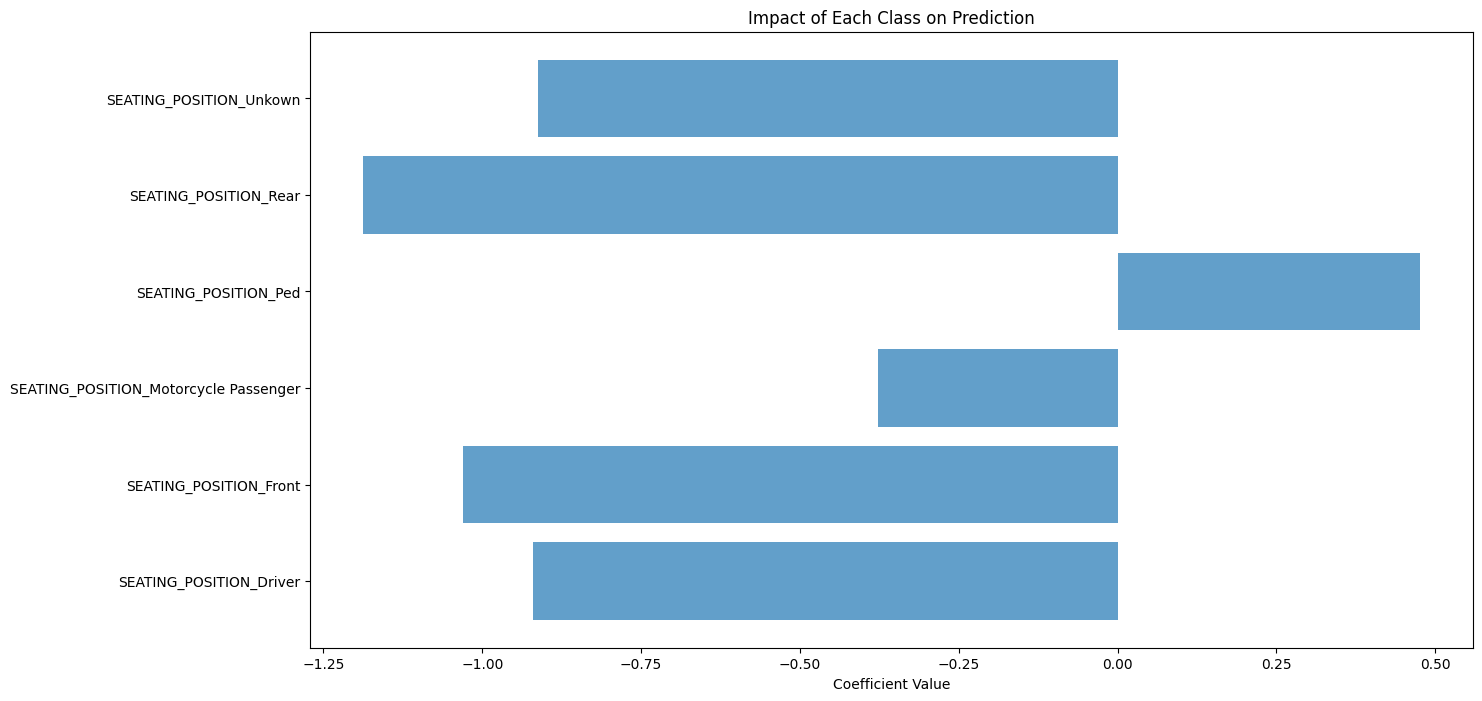

__Helmet__


Helmet
Not appropriate    0.026020
Safety not worn    0.042465
Safety worn        0.006067
Unknown            0.007410
Name: Fatal, dtype: float64

4381.519980087008 0.0
0.07686393675359995
         Current function value: 0.046068
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741110
Model:                          Logit   Df Residuals:                   741105
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.03651
Time:                        00:12:07   Log-Likelihood:                -34142.
converged:                      False   LL-Null:                       -35435.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3469        nan        nan        nan         nan         nan
x1            -0.2756        nan        nan        nan         nan         nan
x2             0.2312        nan        nan        n

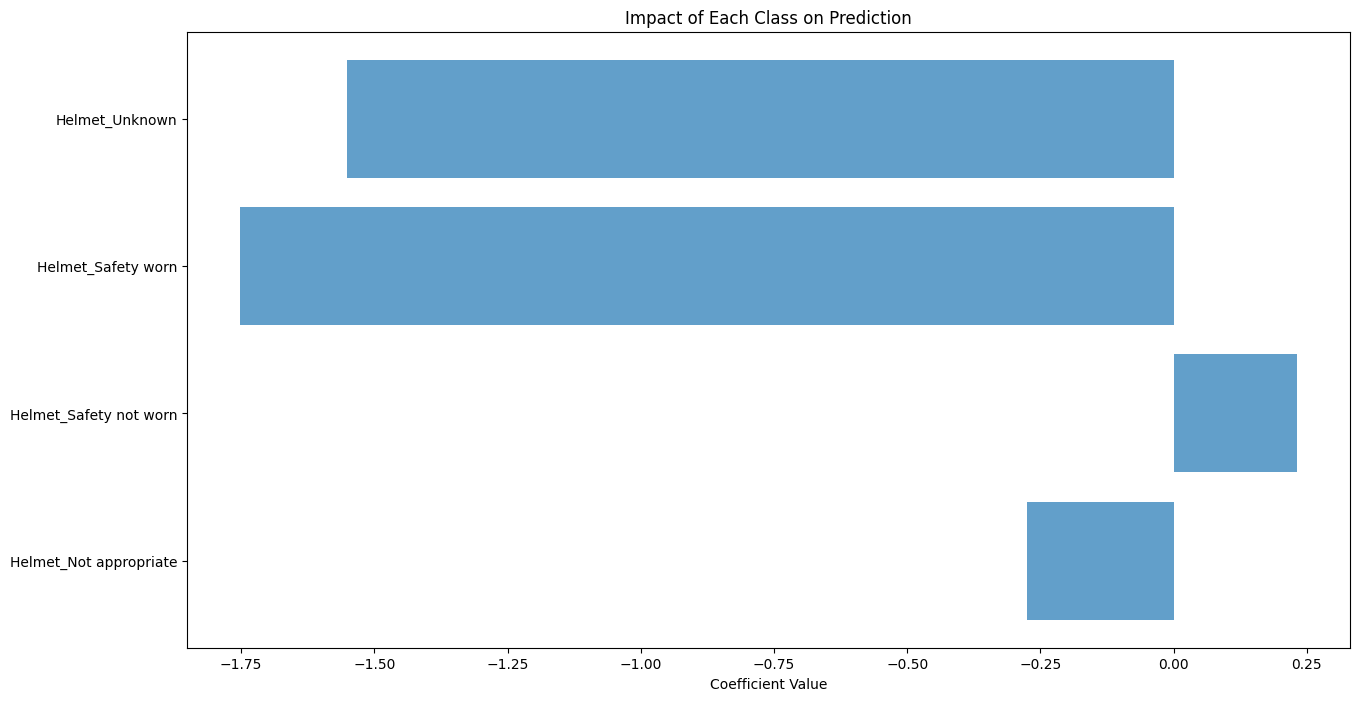

__Road User__


Road User
Cyclist       0.015035
Driver        0.006563
Passenger     0.006575
Pedestrian    0.030029
Name: Fatal, dtype: float64

2369.7731457987666 0.0
0.056867678211605835
         Current function value: 0.047178
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               731857
Model:                          Logit   Df Residuals:                   731852
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.02283
Time:                        00:12:12   Log-Likelihood:                -34528.
converged:                      False   LL-Null:                       -35334.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5390    1.1e+05  -3.21e-05      1.000   -2.16e+05    2.16e+05
x1            -0.6433    1.1e+05  -5.83e-06      1.000   -2.16e+05    2.16e+05
x2            -1.4808    1.1e+05  -1.34e-05      1.0

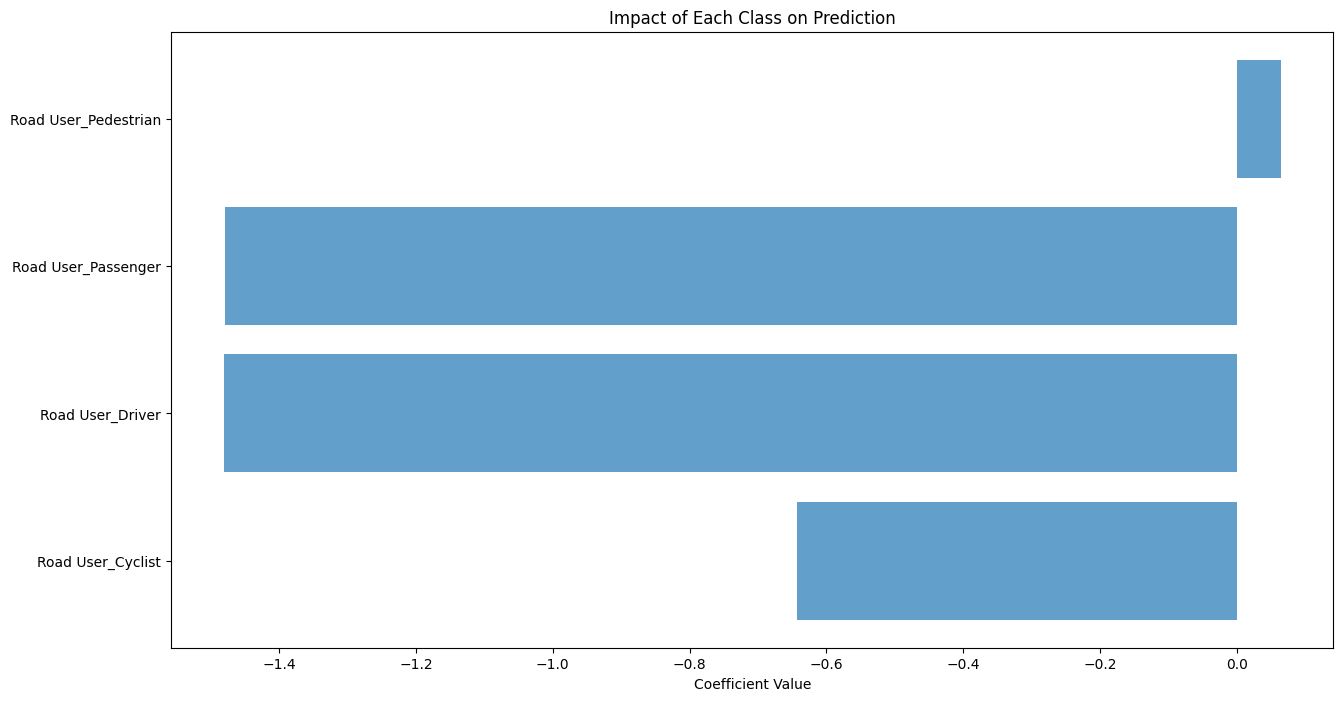

__VEHICLE_YEAR_MANUF__


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp



Optimization terminated successfully.
         Current function value: 0.043135
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               666784
Model:                          Logit   Df Residuals:                   666782
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:               0.0001347
Time:                        00:12:15   Log-Likelihood:                -28761.
converged:                       True   LL-Null:                       -28765.
Covariance Type:            nonrobust   LLR p-value:                  0.005372
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6838      0.082    -57.414      0.000      -4.844      -4.524
x1            -0.0001   4.15

c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp



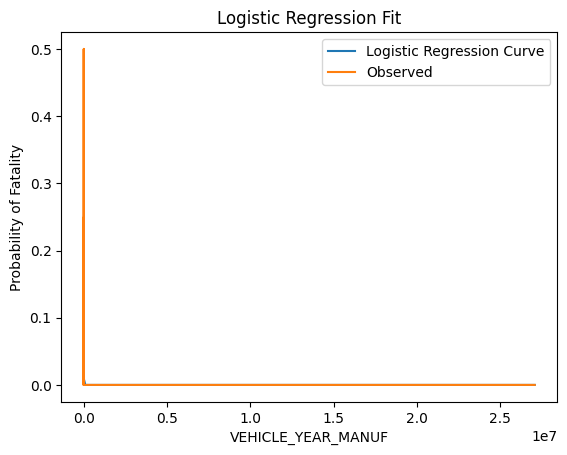

__Road Surface Type Desc__


Road Surface Type Desc
Gravel     0.009410
Paved      0.007257
Ped        0.029994
Unknown    0.004010
Unpaved    0.009776
Name: Fatal, dtype: float64

1897.4312531378591 0.0
0.050545165671971704
         Current function value: 0.047016
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741118
Method:                           MLE   Df Model:                            5
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.01668
Time:                        00:12:20   Log-Likelihood:                -34845.
converged:                      False   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                2.548e-253
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8640        nan        nan        nan         nan         nan
x1            -0.7925        nan        nan        nan         nan         nan
x2            -1.0544        nan        nan        n

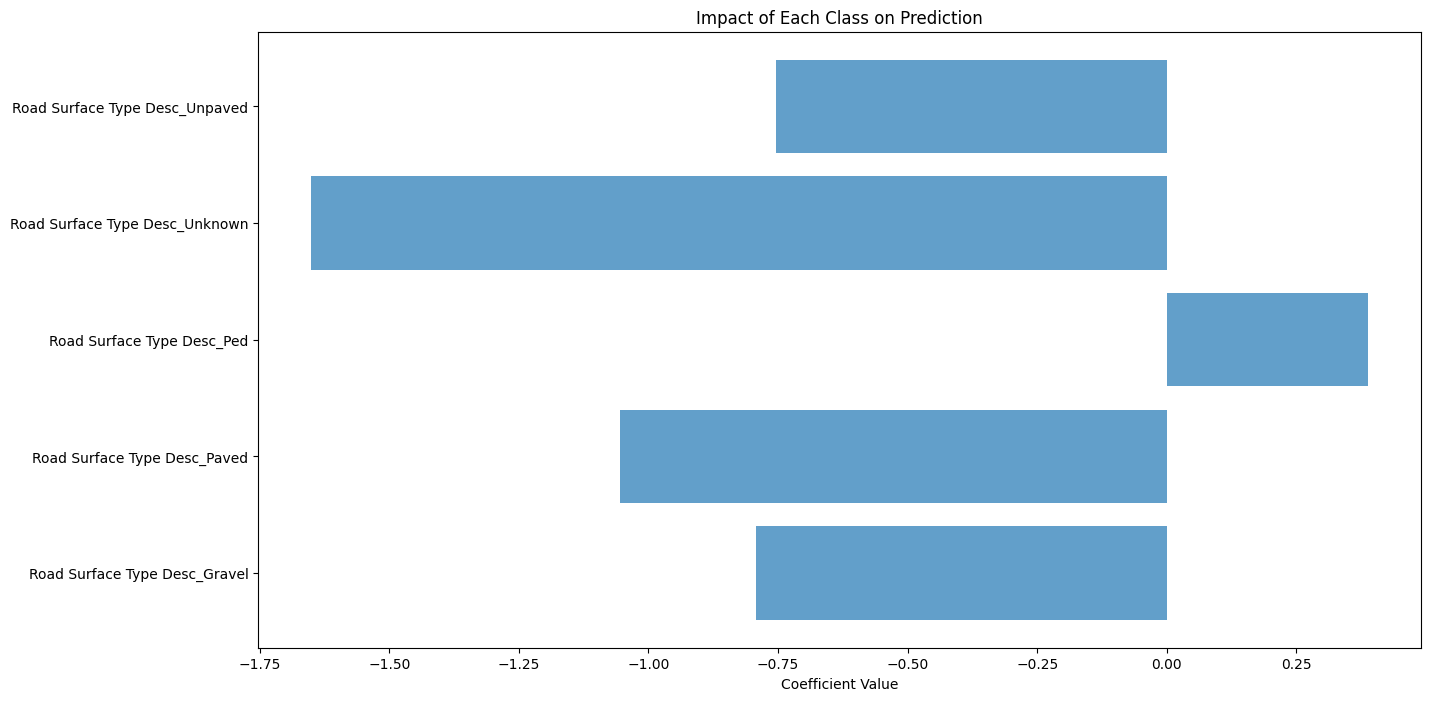

__Vehicle__


Vehicle
Car              0.006504
Large vehicle    0.008220
Motor Cycle      0.015057
Other            0.004478
Pedestrian       0.029994
Station Wagon    0.005429
Name: Fatal, dtype: float64

2479.2553766500787 0.0
0.0577799437966734
         Current function value: 0.046658
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741117
Method:                           MLE   Df Model:                            6
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.02417
Time:                        00:12:25   Log-Likelihood:                -34579.
converged:                      False   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0133        nan        nan        nan         nan         nan
x1            -1.0154        nan        nan        nan         nan         nan
x2            -0.7797        nan        nan        n

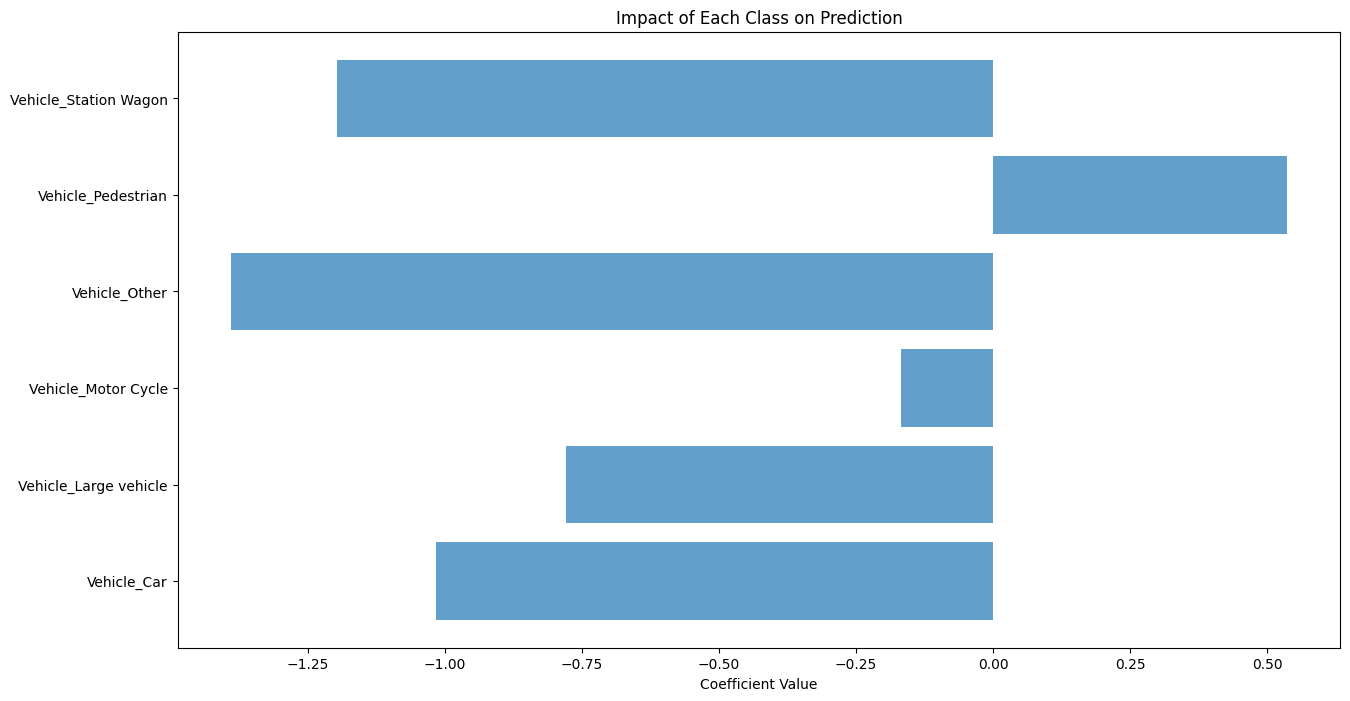

__TOTAL_NO_OCCUPANTS__
Optimization terminated successfully.
         Current function value: 0.047776
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741122
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:               0.0007757
Time:                        00:12:28   Log-Likelihood:                -35408.
converged:                       True   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                 1.219e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6999      0.019   -245.511      0.000      -4.737      -4.662
x1   

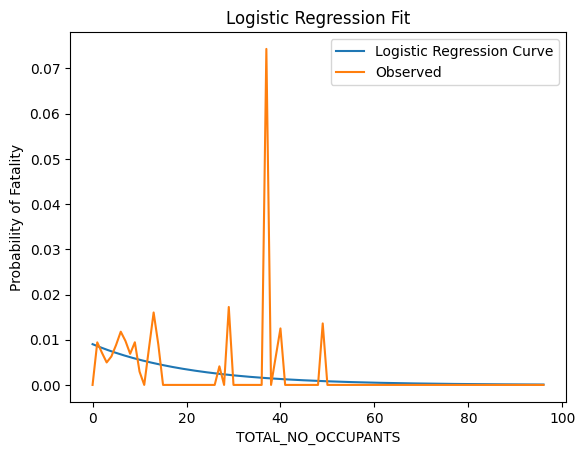

__Weather__


Weather
Clear             0.008575
Low visibility    0.016139
Not known         0.003628
Raining           0.007119
Snowing           0.005208
Strong winds      0.011046
Name: Fatal, dtype: float64

165.2474680332372 7.530946706861995e-34
0.014704505810156329
Optimization terminated successfully.
         Current function value: 0.047692
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741117
Method:                           MLE   Df Model:                            6
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                0.002527
Time:                        00:12:31   Log-Likelihood:                -35346.
converged:                       True   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                 5.348e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1658   8.34e+05  -4.99e-06   

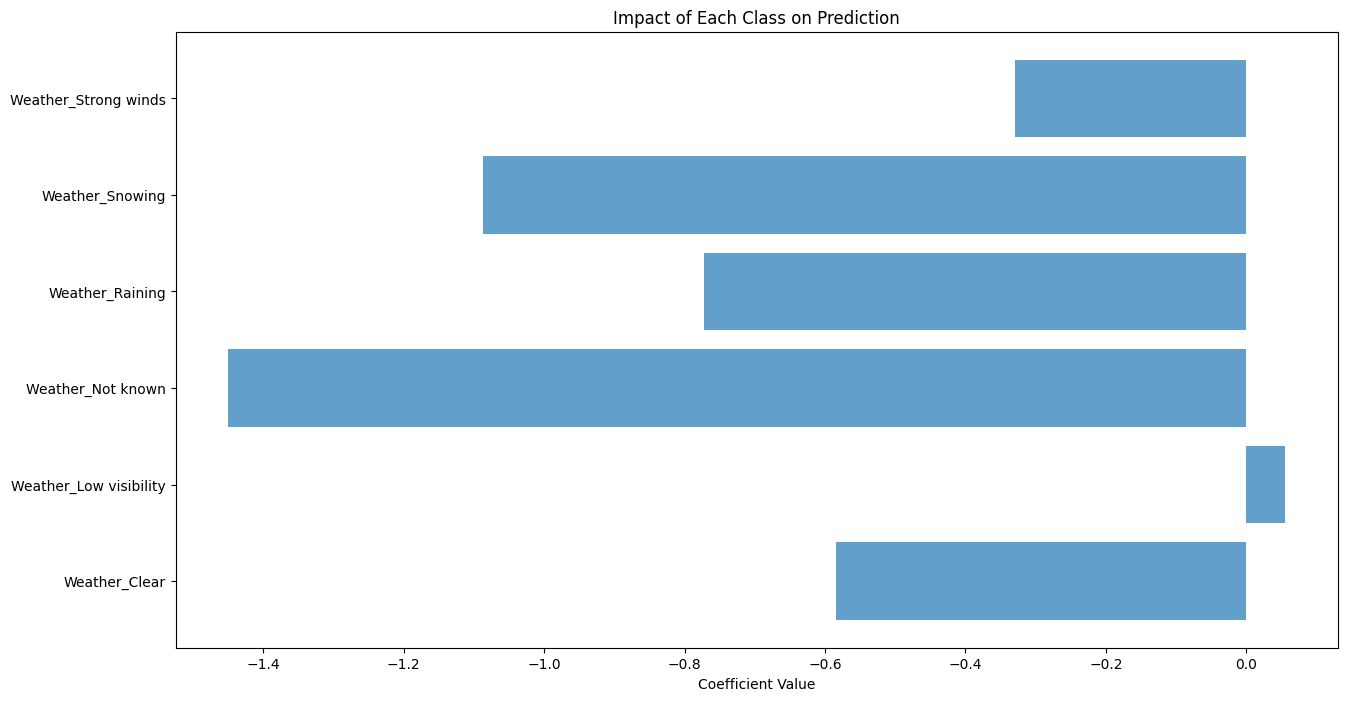

__NODE_TYPE__


NODE_TYPE
     0.000000
I    0.004306
N    0.012338
O    0.010138
Name: Fatal, dtype: float64

1456.0634944284145 0.0
0.04427893327573648
         Current function value: 0.046794
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741119
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.02132
Time:                        00:12:36   Log-Likelihood:                -34680.
converged:                      False   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1680        nan        nan        nan         nan         nan
x1           -10.2645        nan        nan        nan         nan         nan
x2             0.7245        nan        nan        n

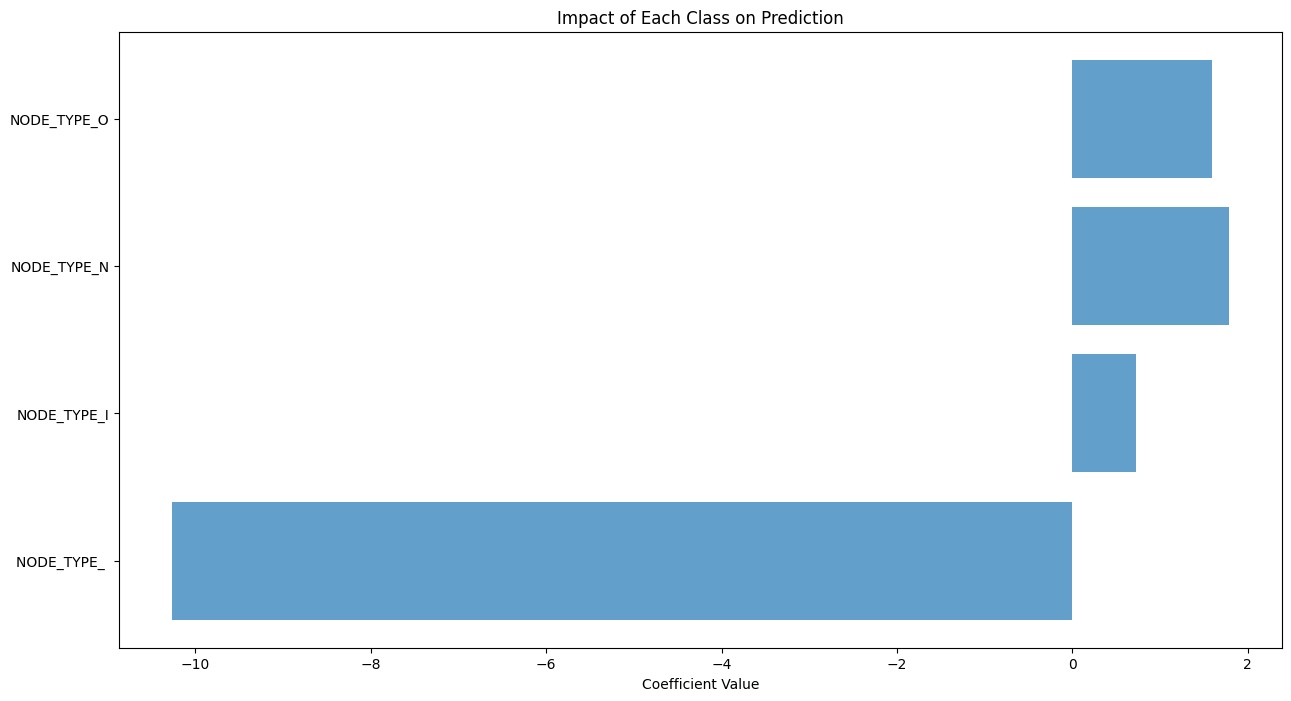

__RA_NAME21__


RA_NAME21
Inner Regional Australia     0.017382
Major Cities of Australia    0.004952
Outer Regional Australia     0.024642
Remote Australia             0.026612
Name: Fatal, dtype: float64

3352.3689210521457 0.0
0.06722585696755472
         Current function value: 0.045975
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741119
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.03846
Time:                        00:12:41   Log-Likelihood:                -34073.
converged:                      False   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3231        nan        nan        nan         nan         nan
x1            -0.7117        nan        nan        nan         nan         nan
x2            -1.9799        nan        nan        n

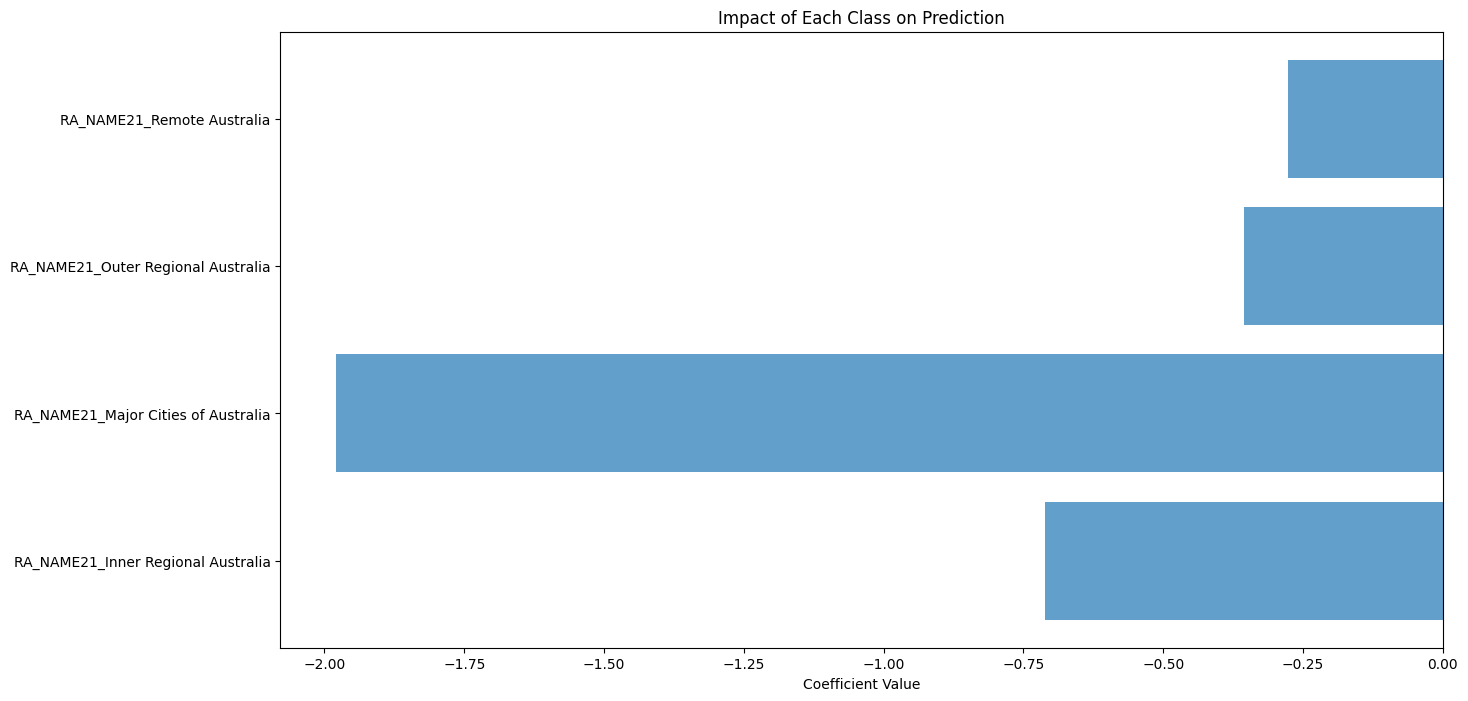

__Surface Cond Desc__


Surface Cond Desc
Dry        0.008567
Icy        0.006865
Muddy      0.007835
Snowy      0.003650
Unknown    0.002979
Wet        0.007855
Name: Fatal, dtype: float64

97.12414030063698 2.1326261262556822e-19
0.011149144967728371
Optimization terminated successfully.
         Current function value: 0.047729
         Iterations 21
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741117
Method:                           MLE   Df Model:                            6
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                0.001771
Time:                        00:12:45   Log-Likelihood:                -35373.
converged:                       True   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                 1.126e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4040   1.73e+05  -2.55e-05  

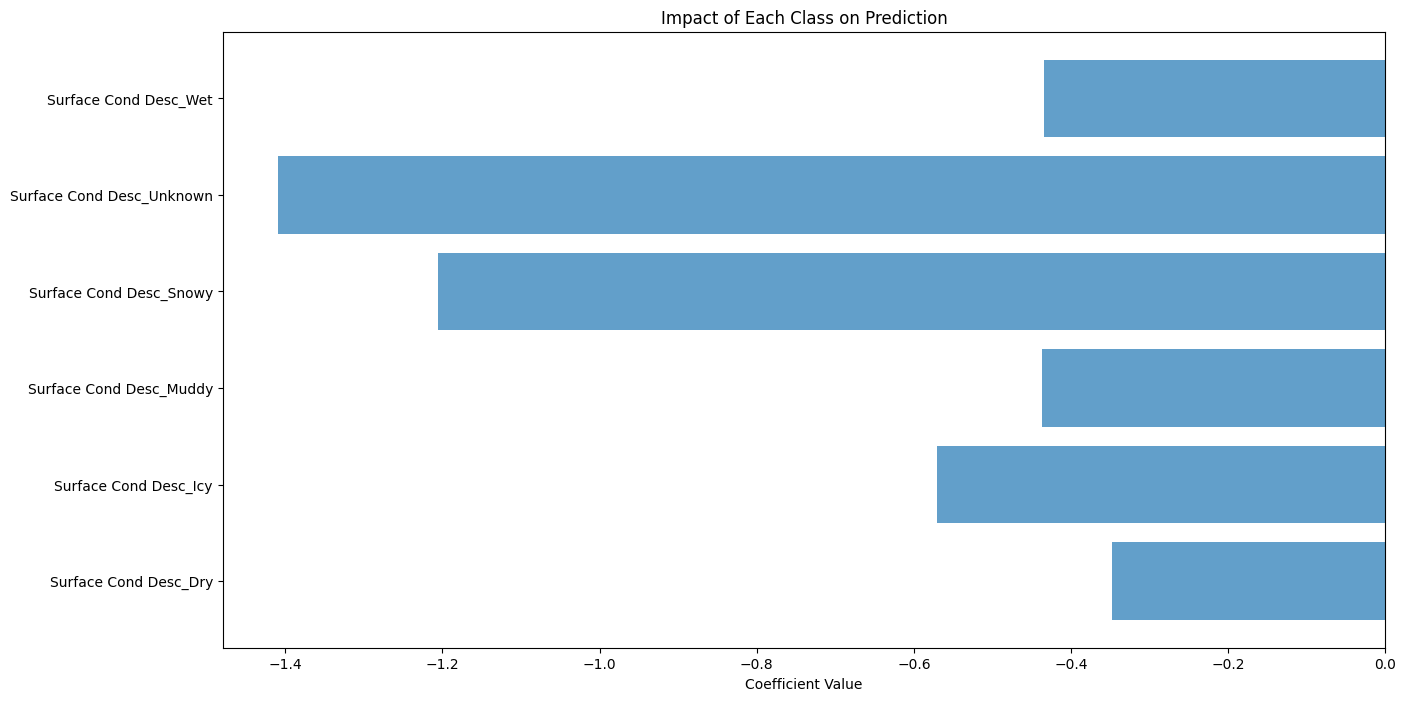

__Light Condition Simple__


Light Condition Simple
Dark         0.013424
Day          0.006547
Dusk/Dawn    0.008211
Unknown      0.003833
Name: Fatal, dtype: float64

766.2853022705651 8.870779561945932e-166
0.03209211228344336
         Current function value: 0.047344
         Iterations: 35


c:\Users\kelvi\anaconda3\envs\blunomy\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741119
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                0.009808
Time:                        00:12:49   Log-Likelihood:                -35088.
converged:                      False   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                3.973e-149
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9347        nan        nan        nan         nan         nan
x1            -0.3624        nan        nan        nan         nan         nan
x2            -1.0874        nan        nan        n

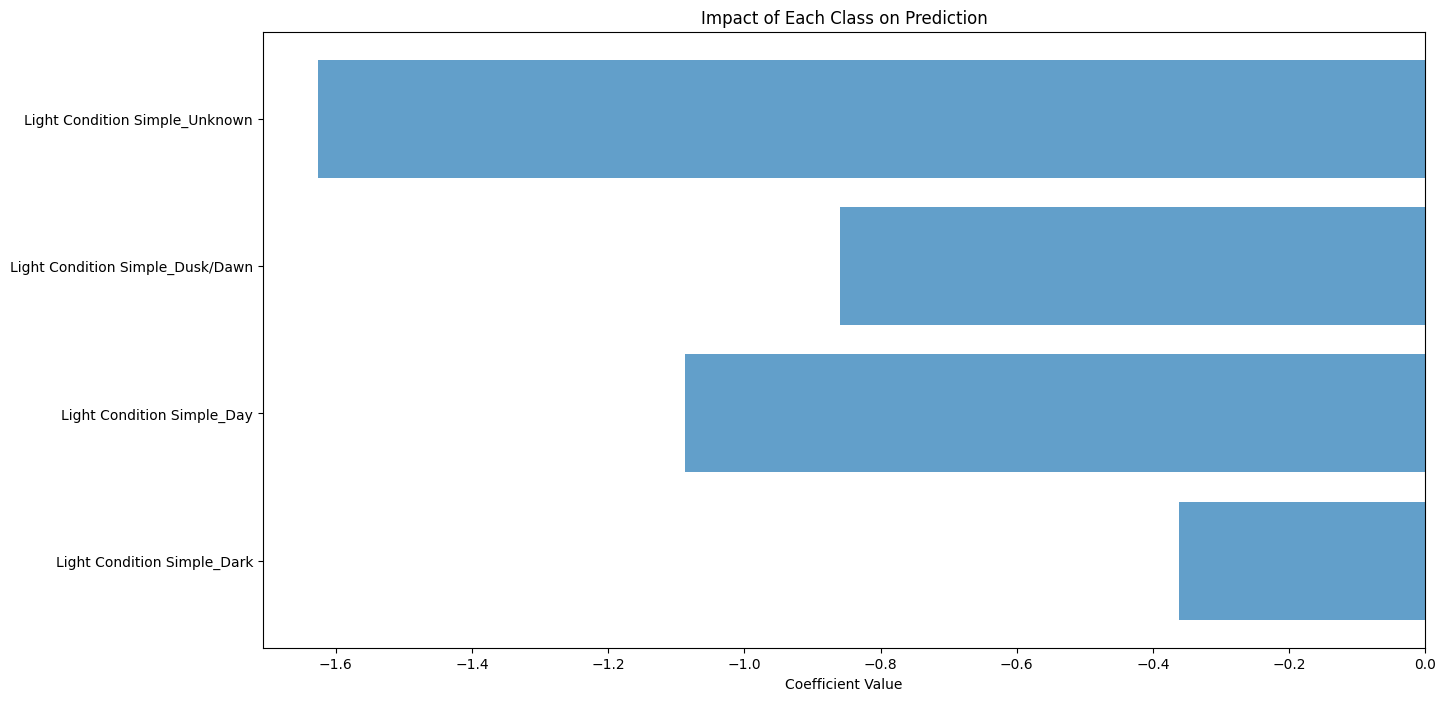

__MONTH__


MONTH
1     0.008837
2     0.008236
3     0.008682
4     0.007687
5     0.008633
6     0.008031
7     0.007921
8     0.007778
9     0.007741
10    0.008330
11    0.008166
12    0.008895
Name: Fatal, dtype: float64

15.463207206591534 0.16225763829406617
0.002454017508992438
Optimization terminated successfully.
         Current function value: 0.047813
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741122
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:               3.474e-06
Time:                        00:12:52   Log-Likelihood:                -35435.
converged:                       True   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                    0.6197
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7768      0.027   -174.699     

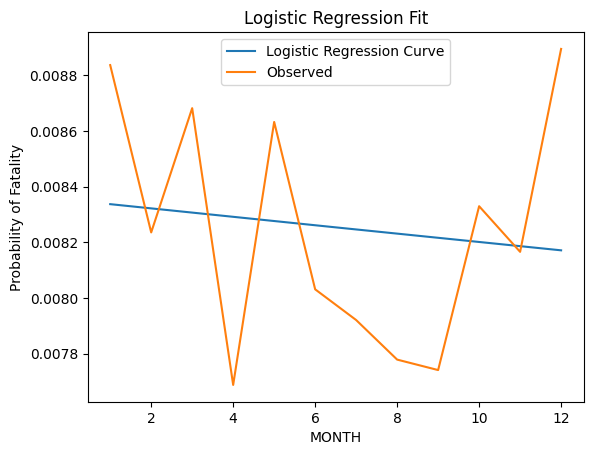

__PEAK__


PEAK
AM peak     0.004631
Off peak    0.008914
PM peak     0.005499
Name: Fatal, dtype: float64

190.23823505239898 4.9010838745840925e-42
0.015939747880100313
Optimization terminated successfully.
         Current function value: 0.047642
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               740876
Model:                          Logit   Df Residuals:                   740872
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                0.003038
Time:                        00:12:55   Log-Likelihood:                -35297.
converged:                       True   LL-Null:                       -35405.
Covariance Type:            nonrobust   LLR p-value:                 2.244e-46
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8198   1.45e+05  -2.63e-05 

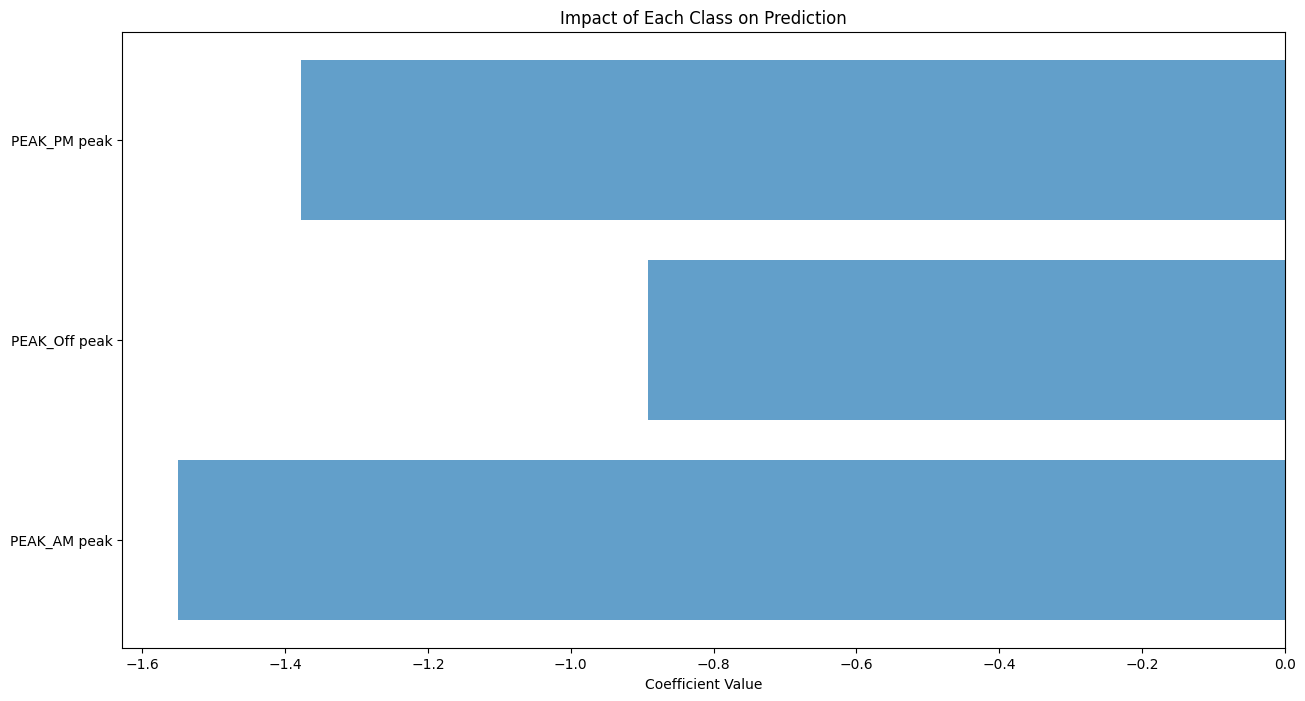

__Node Crash__
Optimization terminated successfully.
         Current function value: 0.047083
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Fatal   No. Observations:               741124
Model:                          Logit   Df Residuals:                   741122
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Sep 2023   Pseudo R-squ.:                 0.01528
Time:                        00:12:58   Log-Likelihood:                -34894.
converged:                       True   LL-Null:                       -35436.
Covariance Type:            nonrobust   LLR p-value:                1.599e-237
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5166      0.015   -305.297      0.000      -4.546      -4.488
x1           

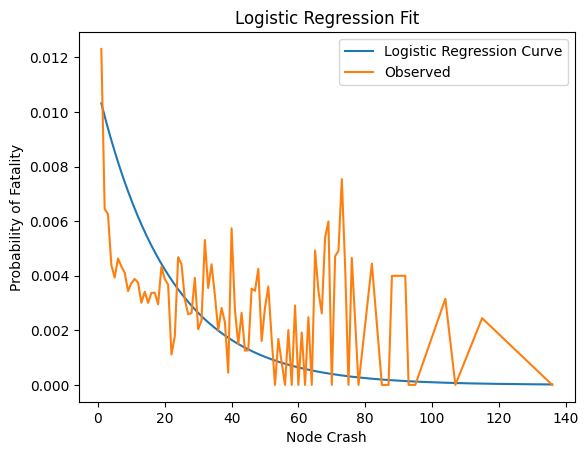

In [1090]:
# Column information
features = []
p_value = []
cramer_values = []

for col in accidents_data.columns:
    if col == 'Fatal':
        continue

    print(f"__{col}__")


    # Logic for determining if data is categorical or not - object trips up on string IDs
    # Threshold for category is arbitrary, anything over 15 probably doesn't fit neatly on a screen
    CHI_THRESH = 15

    if len(accidents_data[col].unique()) < CHI_THRESH:
        display(accidents_data.groupby(col)["Fatal"].mean())

        contingency_table = pd.crosstab(index=accidents_data[col], columns=accidents_data["Fatal"]).values
        chi2, p, _, _ = chi2_contingency(contingency_table)
        cramer = cramers_corrected_stat(contingency_table)

        features.append(col)
        p_value.append(p)
        cramer_values.append(cramer)


        print(chi2, p)
        print(cramer)
    
    categorical = not pd.api.types.is_numeric_dtype(accidents_data[col])
    logistic_regression(accidents_data, col, categorical)

In [1091]:
hypothesis_results_table = pd.DataFrame(zip(features, p_value, cramer_values),columns=["Features","P_value","Cramer_values"])
hypothesis_results_table

,Features,P_value,Cramer_values
0,Accident Type Desc,0.000000e+00,0.080030
1,Day Week Description,2.917334e-22,0.012073
2,SPEED_ZONE,0.000000e+00,0.087400
3,SEX,5.529869e-101,0.025240
4,SEATING_POSITION,0.000000e+00,0.050579
5,Helmet,0.000000e+00,0.076864
6,Road User,0.000000e+00,0.056868
7,Road Surface Type Desc,0.000000e+00,0.050545
8,Vehicle,0.000000e+00,0.057780
9,Weather,7.530947e-34,0.014705


# Final column Selection

In [1092]:
accidents_data["Fatal"].mean()

0.008253679546202795

In [1093]:
px.bar(accidents_data["Fatal"].map({True:"Death",False:"No Death"}).value_counts(),width=600, height=800)

In [1094]:
with open("columns.txt","w") as f:
    for col in accidents_data.columns:
        f.write(f'"{col}", \r')

In [1095]:
columns_to_use = [
"ACCIDENTHOUR", 
"Accident Type Desc", 
"Day Week Description", 
"NO_OF_VEHICLES", 
"NO_PERSONS", 
"SPEED_ZONE", 
# "SEX", # Almost useless
"AGE", 
"SEATING_POSITION", 
"Helmet",
"Road User", 
# "VEHICLE_YEAR_MANUF", 
"Road Surface Type Desc", 
"Vehicle", 
"TOTAL_NO_OCCUPANTS", 
"Weather", 
"NODE_TYPE", 
"Surface Cond Desc", 
"Light Condition Simple", 
# "MONTH", Not significant
"PEAK", 
# "Node Crash",
"RA_NAME21", 
"Fatal", 
]

In [1096]:
cat_columns = [
"Accident Type Desc", 
"Day Week Description", 
"SEATING_POSITION", 
"Road User", 
"Road Surface Type Desc", 
"Helmet",
"Vehicle", 
"Weather", 
"NODE_TYPE", 
"Surface Cond Desc", 
"Light Condition Simple", 
"RA_NAME21", 
"PEAK", 
]

cat_columns = [col for col in cat_columns if col in columns_to_use]

In [1097]:
accidents_data = accidents_data.loc[:,columns_to_use]
accidents_data.info()

# Need to drop NA's since sklearn doesn't deal with them all that well
test_data = accidents_data.dropna()
# For example, to one-hot encode a column named 'road_condition'
test_data = pd.get_dummies(test_data, columns=cat_columns, drop_first=True)

X = test_data.drop("Fatal", axis=1)  # predictor features
y = test_data["Fatal"]  # target variable

<class 'pandas.core.frame.DataFrame'>
Index: 741124 entries, 0 to 744488
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ACCIDENTHOUR            740749 non-null  float64
 1   Accident Type Desc      741124 non-null  object 
 2   Day Week Description    741124 non-null  object 
 3   NO_OF_VEHICLES          741124 non-null  int64  
 4   NO_PERSONS              741124 non-null  int64  
 5   SPEED_ZONE              716648 non-null  float64
 6   AGE                     703853 non-null  float64
 7   SEATING_POSITION        741124 non-null  object 
 8   Helmet                  741110 non-null  object 
 9   Road User               731857 non-null  object 
 10  Road Surface Type Desc  741124 non-null  object 
 11  Vehicle                 741124 non-null  object 
 12  TOTAL_NO_OCCUPANTS      741124 non-null  float64
 13  Weather                 741124 non-null  object 
 14  NODE_TYPE               7

# Model development

Basic model

In [1098]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

rf = RandomForestClassifier(random_state=20)

# Train the model
rf.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9904081331958156
Confusion Matrix:
[[134416     96]
 [  1206     22]]
Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    134512
        True       0.19      0.02      0.03      1228

    accuracy                           0.99    135740
   macro avg       0.59      0.51      0.51    135740
weighted avg       0.98      0.99      0.99    135740



In [1099]:
# Test whether we're overtuned 

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Predictions on the test set
y_pred = rf.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9977898924414321
Confusion Matrix:
[[134498     18]
 [   282    942]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    134516
        True       0.98      0.77      0.86      1224

    accuracy                           1.00    135740
   macro avg       0.99      0.88      0.93    135740
weighted avg       1.00      1.00      1.00    135740



Hyperparameter tuning

In [1100]:
RETRAIN = False

if RETRAIN:
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Initialize SMOTE
    sm = SMOTE(random_state=42)

    # Fit SMOTE to the training data
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    rf = RandomForestClassifier(class_weight='balanced', random_state=20)

    params = {
        'n_estimators': [100, 300, 1000],
        'max_depth': [10, 30],
        'max_features': [10, 21],
        'min_samples_leaf': [80, 150]
    }


    grf_model = GridSearchCV(rf, params, scoring='recall_macro', n_jobs=-1, cv=4)


    # Train the model
    grf_model.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = grf_model.predict(X_test)

    # Best Features
    best_params = grf_model.best_params_
    print(f"Best parameters: {best_params}")

    # Dump to pickle
    with open('../Model/random_forest_model.pkl', 'wb') as f:
        pickle.dump(grf_model, f)
        
    # Model Evaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    best_model = grf_model.best_estimator_
    
else:
    # Prefill from known best hyperparameters
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Create Random Forest Classifier model
    best_model = RandomForestClassifier(n_estimators=300, random_state=20, class_weight='balanced', max_depth=10, min_samples_leaf=150, max_features=21)

    # Train the model
    best_model.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = best_model.predict(X_test)

    # Model Evaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Accuracy: 0.8066082216001179
Confusion Matrix:
[[108506  26006]
 [   245    983]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.81      0.89    134512
        True       0.04      0.80      0.07      1228

    accuracy                           0.81    135740
   macro avg       0.52      0.80      0.48    135740
weighted avg       0.99      0.81      0.88    135740



Feature importance

                                              Feature  Importance
3                                          SPEED_ZONE    0.248413
6           Accident Type Desc_Collision with vehicle    0.107579
4                                                 AGE    0.095226
56                RA_NAME21_Major Cities of Australia    0.071726
1                                      NO_OF_VEHICLES    0.061321
36                                Vehicle_Motor Cycle    0.058580
0                                        ACCIDENTHOUR    0.042505
10               Accident Type Desc_Struck Pedestrian    0.032478
33                                 Helmet_Safety worn    0.031876
2                                          NO_PERSONS    0.026343
32                             Helmet_Safety not worn    0.024045
46                                        NODE_TYPE_N    0.017734
45                                        NODE_TYPE_I    0.017271
38                                 Vehicle_Pedestrian    0.016053
25        

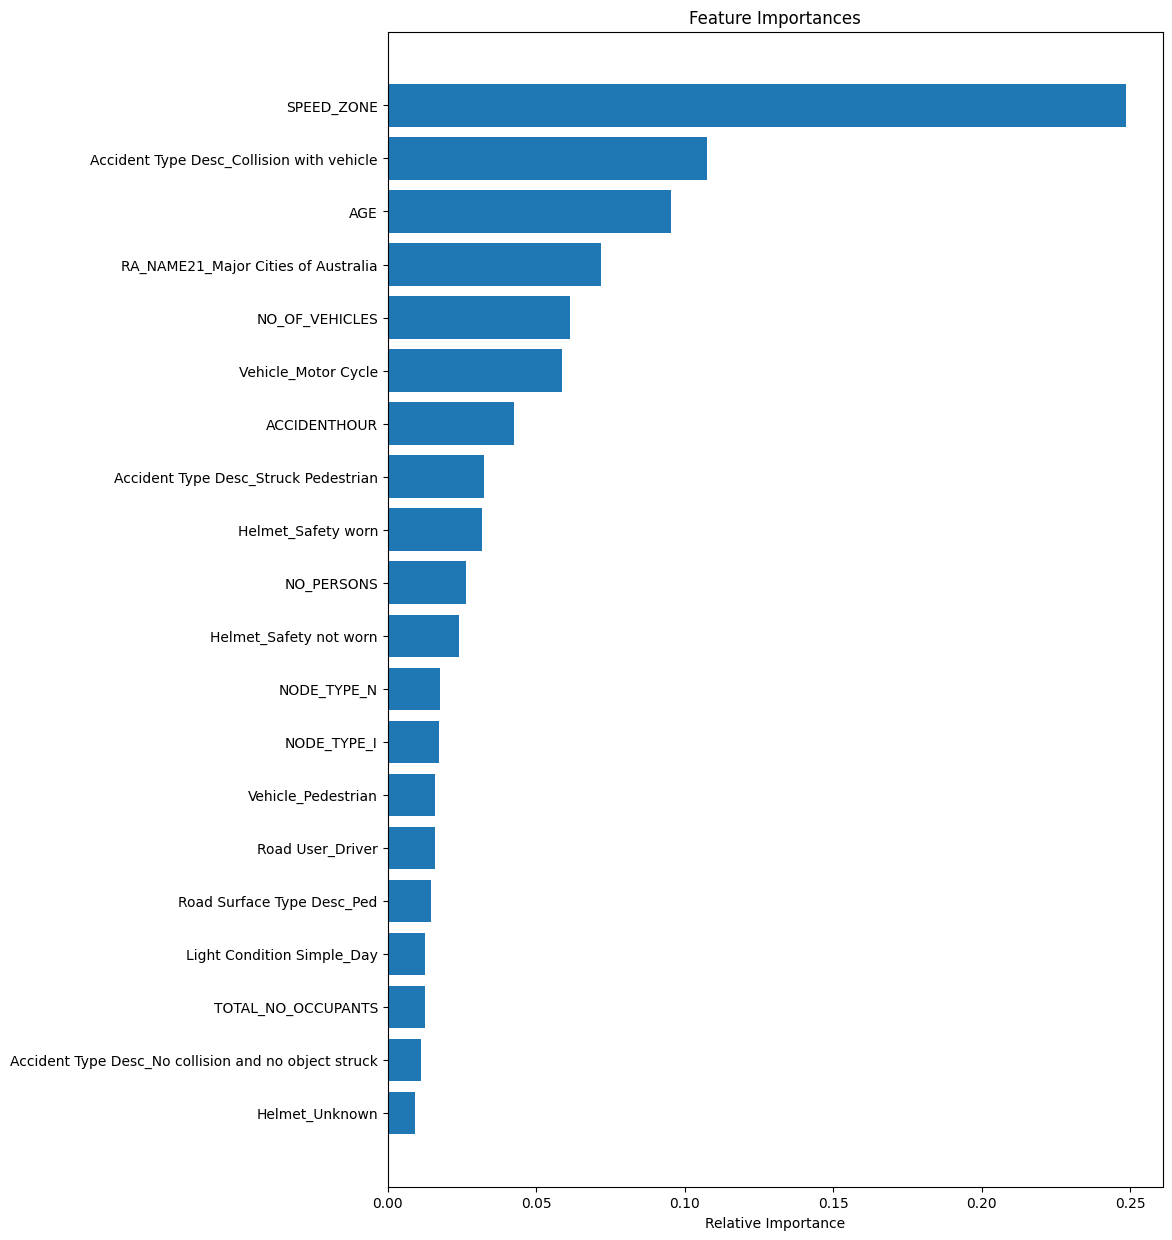

In [1101]:
# Get feature importances
feature_importances = best_model.feature_importances_


# For better visualization, let's put these importances into a DataFrame
import pandas as pd
features = pd.DataFrame({
    'Feature': list(X_train.columns),  # Assuming X_train is a DataFrame
    'Importance': feature_importances
})

# Sort the DataFrame by importances
features = features.sort_values(by='Importance', ascending=False)
features = features.head(20)


# Display
print(features)

# Plotting feature importances
plt.figure(figsize=(10, 15))
plt.title("Feature Importances")
plt.barh(range(len(features['Feature'])), features['Importance'][::-1])
plt.yticks(range(len(features['Feature'])), features['Feature'][::-1])
plt.xlabel('Relative Importance')
plt.show()

Quickly try smote

In [1102]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Initialize SMOTE
sm = SMOTE(random_state=42)

# Fit SMOTE to the training data
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)



# Create Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=500, random_state=20, class_weight='balanced', max_depth=10, min_samples_leaf=150, max_features=21)

# Train the model
rf_model.fit(X_resampled, y_resampled)

# Predictions on the test set
y_pred = rf_model.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9069471047590982
Confusion Matrix:
[[122473  12039]
 [   592    636]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.91      0.95    134512
        True       0.05      0.52      0.09      1228

    accuracy                           0.91    135740
   macro avg       0.52      0.71      0.52    135740
weighted avg       0.99      0.91      0.94    135740

